# Criminal Politicians and Economic Growth: An exploration of Indian Elections during 2004-2009
#### ECON 323 Project by: Mridul Manas, #74732843

## Introduction

My project submission for ECON 323 (w. Prof. Schrimpf) attempts at visualization and analyzing the causal impact of electing candidates accused with criminal charges to legislative assemblies in India between 2004-2009. Inspired from Prakash et al (2019)'s paper, I use data on the criminal history of politicians running elections between 2004-2009, and use the intensity of night-time lights as a proxy for constituency-level economic growth. 

Despite not being personally exposed to econometrics and the theory behind some of the models used in this project, I aim to implement a Regression-Discontinuity setup to study the causal effect of electing criminal politicians. However, along the way, I intend to apply valuable Python skills that I've learnt in this class, such as cleaning, wrangling, reshaping data, writing functions and creating interactive visualizations.  The exposure to RD design will also be valuable preparation for some of the courses I'd be taking in the future (ECON 326, 425 etc.)

#### The project is structured as follows:
1. Loading Packages and Dependencies
2. Loading each of the 4 datasets from SHRUG.
    - Cleaning datasets and studying the variables
3. EDAs on Criminal Records of the Winning and Participating Candidates
4. EDAs on Asset Growth of Elected Candidates
5. Event-Study Plots analyzing effect of electing criminal politicians on Growth of NL-Density
6. Moving towards a RDD Setup
    - Estimating Coefficients based on different definitions for the dependent variable
    - Binned Scatterplots with Lowess Curves to highlight 'jump' in data
7. Discussion on Results
8. Conclusion


#### Loading the packages:

In [547]:
conda install -c conda-forge squarify   

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [548]:
conda install -c conda-forge tabulate

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [41]:
conda install pip

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import squarify
import plotly           #(version 4.5.4) #pip install plotly==4.5.4
import plotly.express as px
import plotly.io as pio

In [48]:
pip install rdd

Note: you may need to restart the kernel to use updated packages.


RDD Code from: https://github.com/evan-magnusson/rdd/blob/master/tutorial/tutorial.ipynb

In [49]:
pip install Babel

Note: you may need to restart the kernel to use updated packages.


In [50]:
from babel.numbers import format_currency

In [51]:
from rdd import rdd

## Loading Datasets
All of the 4 datasets are sourced from Development Data Lab's SHRUG database. 
https://www.devdatalab.org/shrug

### DS1: Constituency-level Night-Lights Data

In [52]:
# This is the night-lights dataset aggregated to 2008 delim Assembly Constituency boundaries
nl_con_2008 = pd.read_csv("data/con_shrug_2008_nl_wide.csv")
# This is the night-lights dataset aggregated to 2007 delim Assembly Constituency boundaries
nl_con_2007 = pd.read_csv("data/con_shrug_2007_nl_wide.csv")

In [53]:
print(nl_con_2008.shape)
nl_con_2008.columns #, nl_con_2007.columns

(4108, 62)


Index(['ac08_id', 'num_cells', 'total_light1994', 'total_light_cal1994',
       'max_light1994', 'total_light1995', 'total_light_cal1995',
       'max_light1995', 'total_light1996', 'total_light_cal1996',
       'max_light1996', 'total_light1997', 'total_light_cal1997',
       'max_light1997', 'total_light1998', 'total_light_cal1998',
       'max_light1998', 'total_light1999', 'total_light_cal1999',
       'max_light1999', 'total_light2000', 'total_light_cal2000',
       'max_light2000', 'total_light2001', 'total_light_cal2001',
       'max_light2001', 'total_light2002', 'total_light_cal2002',
       'max_light2002', 'total_light2003', 'total_light_cal2003',
       'max_light2003', 'total_light2004', 'total_light_cal2004',
       'max_light2004', 'total_light2005', 'total_light_cal2005',
       'max_light2005', 'total_light2006', 'total_light_cal2006',
       'max_light2006', 'total_light2007', 'total_light_cal2007',
       'max_light2007', 'total_light2008', 'total_light_cal2008',
   

### DS2: Elections (Winners) Dataset

Each row in this dataset provides details for an election which occured in a given year inside a given constituency (identified using 'ac_id'). This dataset (DS4) is slightly different from DS3 as it contains characteristics info for only the winning candidate. 

This dataset is useful for my baseline analyses where we are simply looking at elections where criminal vs. non-criminal candidates were elected (regardless of the crime-statuses of other participating candidates). 

In [6]:
elections_raw = pd.read_csv("data/assembly_elections_clean.csv")
elections_raw.columns

Index(['pc01_state_id', 'ac07_id', 'ac08_id', 'tr_ac_id', 'sh_election_id',
       'winner_cand_id', 'pc01_state_name', 'tr_ac_name', 'constituency_type',
       'tr_district_name', 'sub_region', 'delimid', 'assembly_no', 'year',
       'month', 'poll_no', 'bye_election', 'n_cand', 'turnout_percentage',
       'enop', 'winner_name', 'winner_sex', 'winner_party', 'winner_votes',
       'winner_age', 'winner_type', 'winner_valid_votes', 'winner_electors',
       'winner_vshare', 'winner_party_norm', 'pc01_district_name',
       'pc01_district_id', 'ac07_name', 'ac08_name', 'ac_id'],
      dtype='object')

In [7]:
elections_df = elections_raw[["ac_id", "ac08_id", "ac07_id", "year", "winner_cand_id", "sh_election_id", "winner_name"]]
#for col_name in ["ac_id", "winner_cand_id", "sh_election_id", "year"]:
#    print(f"# of rows where {col_name} is missing: {elections_df[col_name].isna().sum()}")

**I am constrained by that fact that I only have night-lights data for the years 2013 or before. Thus, I need to restrict my scope of analysis to elections which occurred during 2004-2009 (assuming we study night-light growth over 4 years before and after any election)**

Note: Prakash et all. (2019) looked at elections which happened during 2004-2008, and I am able to extend the scope of analysis by 2 additional years. 

In [8]:
#limiting scope to [2004, 2009]
elections_df = elections_df.loc[elections_df["year"].isin([2004, 2005,
                                                          2006, 2007, 2009])]
print(f"after reducing scope to 2004-2009: {elections_df.shape[0]} from 40188")

elections_df = elections_df.drop_duplicates(subset = ["ac_id", "year"], keep = 'first').reset_index(drop = True)
print(f"after dropping ac_id, year duplicates: {elections_df.shape[0]}")

#drop rows where any of ac_id, year or constituency name is null. 
elections_df = elections_df.dropna(axis=0, subset=['ac_id', "year"])
print(f"after dropping rows with null values in ac_id, year: {elections_df.shape[0]}")

elections_df.info()

after reducing scope to 2004-2009: 4731 from 40188
after dropping ac_id, year duplicates: 4468
after dropping rows with null values in ac_id, year: 4468
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4468 entries, 0 to 4467
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ac_id           4468 non-null   object
 1   ac08_id         1136 non-null   object
 2   ac07_id         3332 non-null   object
 3   year            4468 non-null   int64 
 4   winner_cand_id  4468 non-null   object
 5   sh_election_id  4468 non-null   object
 6   winner_name     4468 non-null   object
dtypes: int64(1), object(6)
memory usage: 279.2+ KB


### DS3: Elections Candidate Data
Using this dataset, I can retrieve all participating candidates info such as name, sex, performance metrics (ie. position, votes, vote share and etc.), along with election characteristics (ie. turnout percentage in any given election (year) and for any consituency (ac08_id or ac07_id). 

##### TIP: Use this for creating restricted samples. Eg. Top-2

In [9]:
candidates_raw = pd.read_csv("data/assembly_candidates_clean.csv")

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
candidates_raw.head()
candidates_raw.columns

Index(['pc01_state_id', 'ac07_id', 'ac08_id', 'tr_ac_id', 'sh_election_id',
       'sh_cand_id', 'pc01_state_name', 'tr_ac_name', 'constituency_type',
       'tr_district_name', 'sub_region', 'delimid', 'assembly_no', 'year',
       'month', 'poll_no', 'bye_election', 'n_cand', 'turnout_percentage',
       'enop', 'position', 'cand_name', 'sex', 'party', 'votes', 'age',
       'candidate_type', 'valid_votes', 'electors', 'vote_share_percentage',
       'deposit_lost', 'pid', 'normalized_party', 'pc01_district_name',
       'pc01_district_id', 'ac07_name', 'ac08_name', 'ac_id'],
      dtype='object')

In [11]:
candidates = candidates_raw[["ac_id", "ac08_id", "ac07_id", "year", "sh_cand_id", "cand_name", "position", "vote_share_percentage", "tr_ac_name", "pc01_state_name"]]
candidates = candidates.loc[candidates["year"].isin([2004, 2005, 2006, 2007, 2008, 2009])]
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54011 entries, 6 to 355760
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ac_id                  54011 non-null  object 
 1   ac08_id                23786 non-null  object 
 2   ac07_id                30225 non-null  object 
 3   year                   54011 non-null  int64  
 4   sh_cand_id             54011 non-null  object 
 5   cand_name              54011 non-null  object 
 6   position               54011 non-null  float64
 7   vote_share_percentage  53980 non-null  float64
 8   tr_ac_name             54011 non-null  object 
 9   pc01_state_name        54011 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.5+ MB


In [12]:
#candidates.loc[candidates["ac_id"] == "2008-01-001"].sort_values(by = ['year', 'position']).head(5)

### DS4: Affidavits Dataset
Contains affidavit declarations data (including info on criminal history, financial assets, liabilities etc.) for candidates running elections since 2004. 

In [13]:
affidavits_raw = pd.read_csv("data/affidavits_clean.csv")
affidavits_raw.head()

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


year      ac07_id ac08_id        ac_id  adr_cand_id   sh_cand_id  \
0  2007  2007-02-001     NaN  2007-02-001          133  02-11-001-1   
1  2007  2007-02-001     NaN  2007-02-001          134  02-11-001-2   
2  2007  2007-02-001     NaN  2007-02-001          193          NaN   
3  2007  2007-02-001     NaN  2007-02-001          194          NaN   
4  2007  2007-02-002     NaN  2007-02-002           83  02-11-002-1   

  sh_election_id  pc01_state_id   pc01_state_name adr_district_name  ...  \
0      02-11-001              2  himachal pradesh           kinnaur  ...   
1      02-11-001              2  himachal pradesh           kinnaur  ...   
2      02-11-001              2  himachal pradesh           kinnaur  ...   
3      02-11-001              2  himachal pradesh           kinnaur  ...   
4      02-11-002              2  himachal pradesh            shimla  ...   

    age    ed      assets  liabilities  num_crim  party  winner bye_election  \
0  47.0  12.0  10065000.0    1204639.0         1    BJP       1            0   
1  51.0  14.0   8145367.0    2500000.0         0    INC       0            0   
2  37.0  12.0   4105000.0     542000.0         5    BSP       0            0   
3  46.0  10.0   1151000.0     150000.0         0    LJP       0            0   
4  53.0  14.0   2256373.0     270580.0         0    INC       1            0   

   adr_major_crime  punishment  
0              0.0         0.5  
1              0.0         0.0  
2              1.0        10.0  
3              0.0         0.0  
4              0.0         0.0  

[5 rows x 22 columns]

In [14]:
affidavits_raw.columns

Index(['year', 'ac07_id', 'ac08_id', 'ac_id', 'adr_cand_id', 'sh_cand_id',
       'sh_election_id', 'pc01_state_id', 'pc01_state_name',
       'adr_district_name', 'adr_con_name', 'adr_cand_name', 'age', 'ed',
       'assets', 'liabilities', 'num_crim', 'party', 'winner', 'bye_election',
       'adr_major_crime', 'punishment'],
      dtype='object')

In [15]:
#drop rows where any of ac_id, year or winner is null.
affidavits = affidavits_raw.loc[affidavits_raw["year"].isin([2004, 2005, 2006, 2007, 2008, 2009])]
print(affidavits.shape[0])        

affidavits = affidavits.loc[-affidavits_raw["ac_id"].isnull()]
print(affidavits.shape[0])

affidavits = affidavits.loc[-affidavits["winner"].isnull()]
print(affidavits.shape[0])

#For baseline case, we only need info for the election winners if we're joining with elections dataset.
#affidavits = affidavits.loc[affidavits["winner"] == 1]
##print(affidavits.shape[0])

#select columns required for analysis. 
affidavits = (affidavits[["ac_id", "ac07_id", "ac08_id", "year", "adr_cand_name", "sh_cand_id",
                                     "num_crim", "party", "winner", "adr_major_crime",
                                     "punishment"]])
                                    
affidavits.info()


31280
31280
31280
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31280 entries, 0 to 86465
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ac_id            31280 non-null  object 
 1   ac07_id          10377 non-null  object 
 2   ac08_id          20903 non-null  object 
 3   year             31280 non-null  int64  
 4   adr_cand_name    31280 non-null  object 
 5   sh_cand_id       8593 non-null   object 
 6   num_crim         31280 non-null  int64  
 7   party            31280 non-null  object 
 8   winner           31280 non-null  int64  
 9   adr_major_crime  31015 non-null  float64
 10  punishment       31015 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 2.9+ MB


In [16]:
affidavits_raw.columns

Index(['year', 'ac07_id', 'ac08_id', 'ac_id', 'adr_cand_id', 'sh_cand_id',
       'sh_election_id', 'pc01_state_id', 'pc01_state_name',
       'adr_district_name', 'adr_con_name', 'adr_cand_name', 'age', 'ed',
       'assets', 'liabilities', 'num_crim', 'party', 'winner', 'bye_election',
       'adr_major_crime', 'punishment'],
      dtype='object')

### EDA: How many elections worth of data do we have for each constituency?¶
It'd be interesting to see if we have enough number of constituencies for which we have data for multiple elections including the criminal records of the winning candidates. 

In [17]:
affidavits["sh_cand_id"].isna().sum()

22687

Not all rows in the affidavits dataset have a 'sd_cand_id', thus I need to look for other keys to join the two datasets. Fortunately, I can use the 'year' and 'ac_id' keys to join the two datasets (think of this as merging on the basis on election(year)-constituency(ac_id) pairs). Because I am only looking at election winners at this stage, a election(year)-constituency(ac_id) pair ends up being unique, ie. corresponds to only one row or observation in each of the two datasets. 

Merging on the basis of year-constituency makes sense since the criminal records of a single candidate may change over time, ie. from election to election, and thus this merge lets us maintain an accurate record of criminal charges of the winning candidate for each election. 

In [18]:
affidavits_winners = affidavits.loc[affidavits.winner == 1]
gen_elections = pd.merge(elections_df, affidavits_winners, on=['ac_id','year'], how = "inner")
gen_elections = gen_elections.drop_duplicates(subset = ["ac_id", "year"], keep = 'first')
print(f'There were {elections_df.shape[0] - gen_elections.shape[0]} elections for which the criminal records of winning candidates are not available.')

There were 839 elections for which the criminal records of winning candidates are not available.


In [19]:
results = {}

def run_this(df): 
    for ac_id in df["ac_id"].unique():
        subset = df.loc[df["ac_id"] == ac_id]
        result = {ac_id : subset.shape[0]}
        results.update(result)
    return results

result = run_this(gen_elections)
result_df = pd.DataFrame(result.items(), columns = ["Constituency", "No. of Elections"])
list_multiple_elections = result_df.loc[result_df["No. of Elections"] > 1]["Constituency"]




result_df = result_df.groupby("No. of Elections").count().reset_index()
result_df = result_df.rename(columns={"Constituency": "No. of Constituencies"})
result_df["Log of # of Constituencies"] = np.log(result_df["No. of Constituencies"])


print(result_df)
#print(tabulate(result_df, headers='keys', tablefmt='github'))


   No. of Elections  No. of Constituencies  Log of # of Constituencies
0                 1                   3629                    8.196712


It's interesting to note that each ac_id in the gen_elections dataset, in the subsets created later in this project, corresponds to only one election which occurred during 2004-2009. This makes it difficult to answer some questions such as 'for constituencies where incumbent candidate is a non-criminal but the new winning candidate is criminal, how does yearly economic growth change?', as we don't know about what happened in any constituency before the given year of election. However, the uniqueness of each ac_id in the gen_elections df makes a few other things easier for me, especially while reshaping datasets and creating some complex visualizations in later part of this project. 

### EDA: Studying Criminal Records of Election Winners
My baseline definiton of criminal status of a candidate is whether the candidate has any (at least 1) criminal case against them (can take one of either values 1 and 0). In later parts of this project, I refine my definition of criminality by only considering a candidate criminal if they have more than 2 crimes against them. The definition is then further refined by creating another threshold: candidate is considered criminal iff they have at least 5 criminal charges against them. My choice of threshold is consistent with Prakash et all (2019).

To move ahead, I need to merge the 'elections_df' dataset which contains information about election winners with 'affidavits' dataset which contains information about all candidates' affidavits (incl. criminal records). 

#### Plotting distribution of Election winning candidates based on # of Criminal Charges faced

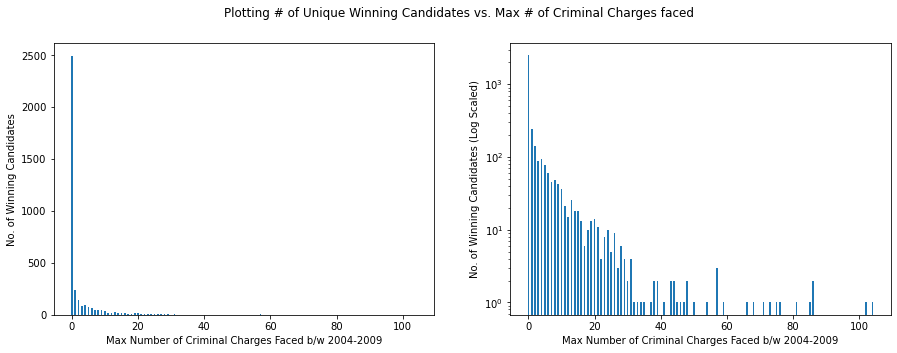

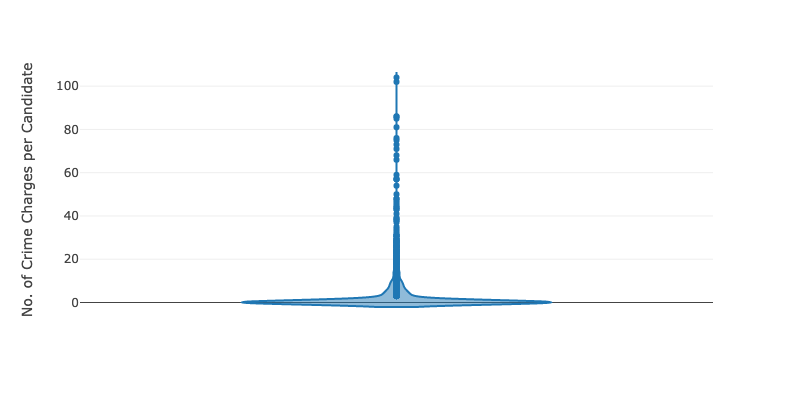

<Figure size 432x288 with 0 Axes>

In [20]:
ncrim_by_cand = pd.DataFrame(gen_elections.groupby("winner_cand_id").num_crim.max()).reset_index()
ncand_by_ncrim = pd.DataFrame(ncrim_by_cand.groupby("num_crim").winner_cand_id.count()).reset_index()

n_crim = ncand_by_ncrim["num_crim"]
n_cand = ncand_by_ncrim["winner_cand_id"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.bar(n_crim, n_cand, width = 0.5)
ax2.bar(n_crim, n_cand, width = 0.5)


ax2.set_yscale('log')
ax1.set_xlabel('Max Number of Criminal Charges Faced b/w 2004-2009')
ax2.set_xlabel('Max Number of Criminal Charges Faced b/w 2004-2009')

ax1.set_ylabel('No. of Winning Candidates')
ax2.set_ylabel('No. of Winning Candidates (Log Scaled)')

fig.suptitle("Plotting # of Unique Winning Candidates vs. Max # of Criminal Charges faced")
plt.show()
plt.tight_layout()

#Now a distribution of variable: # of crimes per each candidate
ncrim_dist = gen_elections.groupby("winner_cand_id").num_crim.max().values

fig2 = px.violin(ncrim_dist, height = 400,
                labels = {'value' : 'No. of Crime Charges per Candidate', 'variable': ''},
               # title = 'Violin Plot: Distribution of # of Crimes per Elected Candidate',
                template = 'gridon')
fig2.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [],
        ticktext = []
    )
)

fig2.show()

If we look at all the unique candidates who won at least one election between 2004 and 2009, we find that majority of these unique candidates have zero (0) crime charges against them. Then, we have a long a tail of outliers which some candidates having as many as 20 criminal charges against them. Caution must be taken, however, when we look at data points at the extreme right of the bar charts or the extreme top of the boxplots: data points (num_crim) greater than 20 are more likely to be cases of bad data (eg. overcounting) as explored later in this project. 

Next we ask, what were the different proportions of elections during 2004-2009 won by different groups of candidates classified based on their criminal statuses:

#### No. of Criminal MPs and Criminal Candidates along the Years

In [608]:
df = pd.DataFrame(gen_elections.groupby(['year', 'winner_cand_id']).num_crim.max())
df = df.reset_index().set_index('year')
winners_by_year = pd.DataFrame(df.groupby('year').winner_cand_id.count()).reset_index()
winners_by_year

df_crim = df.loc[df['num_crim'] >= 1]
#df_crim = df_crim.reset_index().set_index('year')
crim_winners_by_year = pd.DataFrame(df_crim.groupby('year').winner_cand_id.count()).reset_index()
crim_winners_by_year

from plotly.subplots import make_subplots
#fig = go.Figure()

fig = go.Figure()
fig.add_trace(go.Scatter(x = crim_winners_by_year['year'], y = crim_winners_by_year['winner_cand_id'],
                        name = 'Elected Criminal Candidates',
                        line=dict(color = '#ca6148', width=2),
                        fill='tozeroy'))
fig.add_trace(go.Scatter(x = winners_by_year['year'], y = winners_by_year['winner_cand_id'],
                        name = 'All Elected Candidates',
                        line=dict(color = 'rgb(189,189,189)', width=2),
                        fill='tonexty'))

fig = fig.update_layout(
            title_text='Criminal Candidates Winning Elections during 2004-2009,<b> rising steadily </b>',
            title_x=0.5,
            plot_bgcolor= '#ffffff',
            height = 450,
            hoverlabel=dict(font_size=10, bgcolor='rgb(69, 95, 154)',
            bordercolor= 'whitesmoke'),
            legend=dict(x=0,
                        y=1,
                        traceorder='normal',
                        #bgcolor=,
                        xanchor = 'auto'),
            yaxis = dict(
              showgrid = True,
              zeroline = True,
              showline = True,
              gridcolor = '#eeeeee',
              gridwidth = 1.618,
              ##zerolinecolor = '#ffffff',
              #zerolinewidth = 1.618,
              linewidth = 1,
              title = '# of Unique Winning Candidates',
              titlefont = dict(
                 size = 11,
                 color = '#444444'
              )),
              xaxis = dict(
              showgrid = False,
              zeroline = True,
              gridcolor = '#eeeeee',
              gridwidth = 2,
              #zerolinecolor = 'LIGHTBLUE',
              #zerolinewidth = 4,
              linewidth = 1,
              title = 'Year of Election',
              titlefont = dict(
                 size = 11,
                 color = '#444444'))
            )
fig = fig.update_traces(mode="lines+markers", hovertemplate= '%{y} candidates won elections in %{x}')

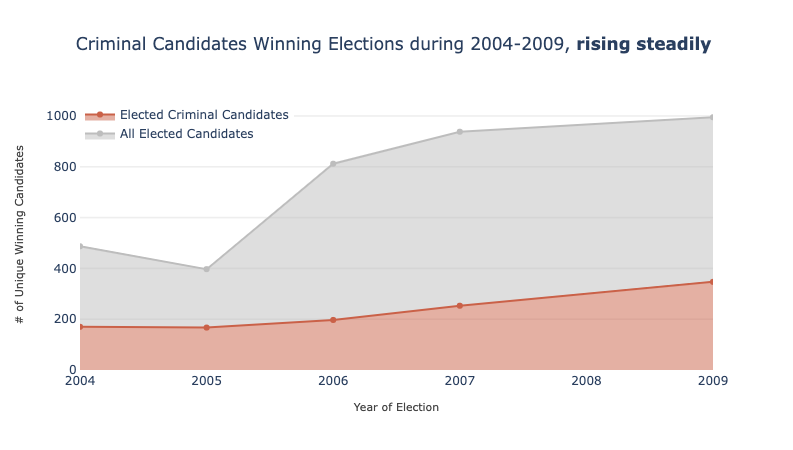

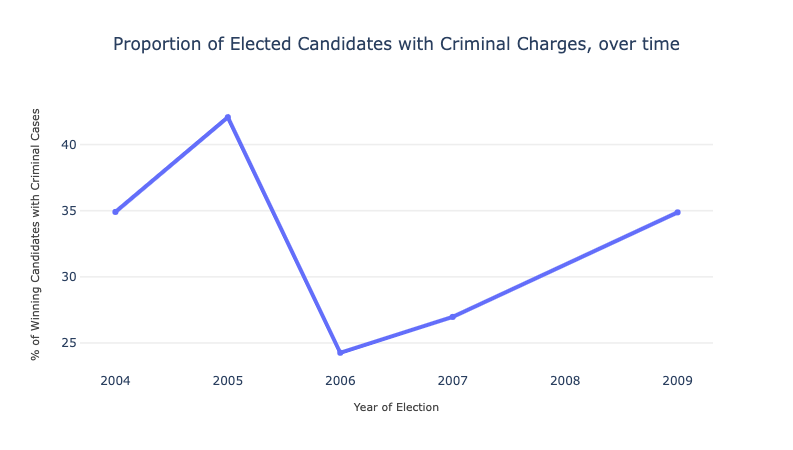

In [609]:
#Now plot % of criminal winners per each year:
df2 = pd.merge(winners_by_year, crim_winners_by_year, on = 'year')
df2 = df2.rename(columns = {'winner_cand_id_x' : 'n_winners', 
                           'winner_cand_id_y': 'n_crimwinners'})
df2['prop'] = (df2['n_crimwinners'] / df2['n_winners']) * 100

df2 = pd.merge(winners_by_year, crim_winners_by_year, on = 'year')
df2 = df2.rename(columns = {'winner_cand_id_x' : 'n_winners', 
                           'winner_cand_id_y': 'n_crimwinners'})
df2['prop'] = (df2['n_crimwinners'] / df2['n_winners']) * 100

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x = df2['year'], y = df2['prop'],
                        name = '% of Criminal Candidates',
                        line=dict(width=4)))

fig2 = fig2.update_layout(
            title_text='Proportion of Elected Candidates with Criminal Charges, over time',
            title_x=0.5,
            plot_bgcolor= '#ffffff',
            height = 450,
            hoverlabel=dict(font_size=10, bgcolor='rgb(69, 95, 154)',
            bordercolor= 'whitesmoke'),
            legend=dict(x=0,
                        y=1,
                        traceorder='normal',
                        #bgcolor=,
                        xanchor = 'auto'),
            yaxis = dict(
              showgrid = True,
              zeroline = True,
              showline = True,
              gridcolor = '#eeeeee',
              gridwidth = 1.618,
              ##zerolinecolor = '#ffffff',
              #zerolinewidth = 1.618,
              linewidth = 1,
              title = '% of Winning Candidates with Criminal Cases',
              titlefont = dict(
                 size = 11,
                 color = '#444444'
              )),
              xaxis = dict(
              showgrid = False,
              zeroline = True,
              gridcolor = '#eeeeee',
              gridwidth = 2,
              #zerolinecolor = 'LIGHTBLUE',
              #zerolinewidth = 4,
              linewidth = 1,
              title = 'Year of Election',
              titlefont = dict(
                 size = 11,
                 color = '#444444'))
            )
fig2 = fig2.update_traces(mode="lines+markers", hovertemplate= '%{y}% of candidates won elections in %{x} were charged with crime(s)')

fig.show()
fig2.show()

#### How Did Criminal Candidates Fare In All Indian Elections During 2004-2009

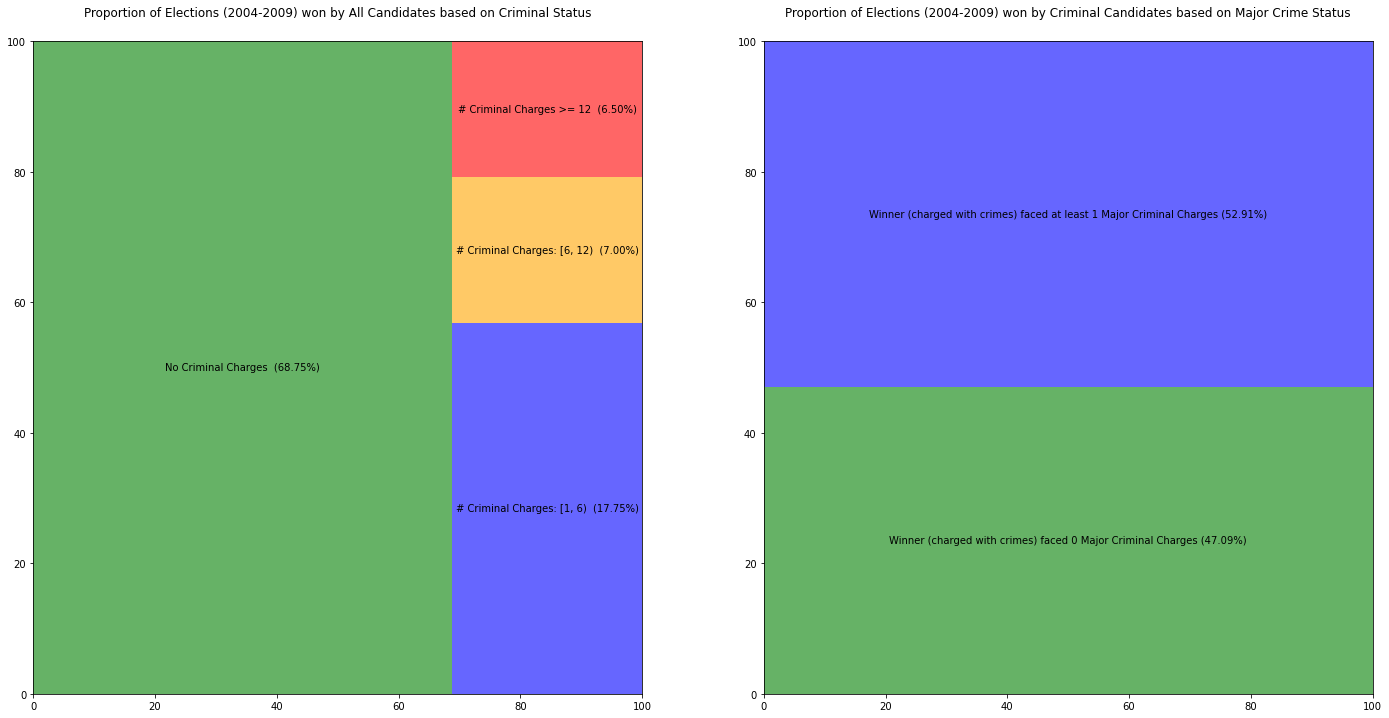

In [610]:
#creating different subsets of elections based on crime statuses of the winning candidates
non_crim = gen_elections.loc[gen_elections["num_crim"] == 0].shape[0]
crim_1to6 = gen_elections.loc[(gen_elections["num_crim"] >= 1) & (gen_elections["num_crim"] < 6)].shape[0]
crim_6to12 = gen_elections.loc[(gen_elections["num_crim"] >= 6) & (gen_elections["num_crim"] < 12)].shape[0]
crim_12andgreater = gen_elections.loc[(gen_elections["num_crim"] >= 12)].shape[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 12))

#Out of all elections during 2004-2009, what were the proportions won by different groups of candidates
# based on their criminal status?
sizes1 = [non_crim, crim_1to6, crim_6to12, crim_12andgreater]
percentages = ([str('{:.2f}%'.format((n_rows/gen_elections.shape[0])*100)) for 
                n_rows in [non_crim, crim_1to6, crim_6to12, crim_12andgreater]])

labels1=[str('No Criminal Charges  ({})'.format(percentages[0])), 
         str('# Criminal Charges: [1, 6)  ({})'.format(percentages[1])), 
         str('# Criminal Charges: [6, 12)  ({})'.format(percentages[2])), 
         str('# Criminal Charges >= 12  ({})'.format(percentages[3]))]
color=['green','blue','orange','red']
squarify.plot(sizes=sizes1, label=labels1, alpha=0.6, color = color, ax = ax1)
ax1.set_title("Proportion of Elections (2004-2009) won by All Candidates based on Criminal Status", pad = 25)

#Now, out of all elections won by criminal candidates, how many of them were won by major criminals?
crim_elections = gen_elections.loc[gen_elections["num_crim"] != 0]
sizes2 = [crim_elections.loc[crim_elections["adr_major_crime"] != 1.0].shape[0], 
          crim_elections.loc[crim_elections["adr_major_crime"] == 1.0].shape[0]]

percentages2 = ([str('{:.2f}%'.format((n_rows/crim_elections.shape[0])*100)) for 
                n_rows in [crim_elections.loc[crim_elections["adr_major_crime"] != 1.0].shape[0], 
                           crim_elections.loc[crim_elections["adr_major_crime"] == 1.0].shape[0]]])
labels2=[str("Winner (charged with crimes) faced 0 Major Criminal Charges ({})").format(percentages2[0]), 
         str("Winner (charged with crimes) faced at least 1 Major Criminal Charges ({})").format(percentages2[1])]

squarify.plot(sizes=sizes2, label=labels2, alpha=0.6, color = color, ax = ax2)
ax2.set_title("Proportion of Elections (2004-2009) won by Criminal Candidates based on Major Crime Status", pad = 25)

plt.show()

It is still quite unsettling to note that about 31.25% of Indian elections between 2004-2009 were won by candidates with at least 1 criminal charge against them. Slightly more unsettling is the fact that out of all the elections won by a criminal candidate (ie. facing 1 or more crime charges), a little over half (52.91%) were won by candidates charged with serious (ie. financial, murder or fraud related) crime(s). 

### Are the arch-rivals at national level, INC and BJP, any different in terms of pitching criminal candidates? 
I also look at how parties like JD(U) and BSP that are largely restricted to two of the poorest states in India (Bihar and Uttar Pradesh, respectively) fare in terms of their share of criminal candidates?

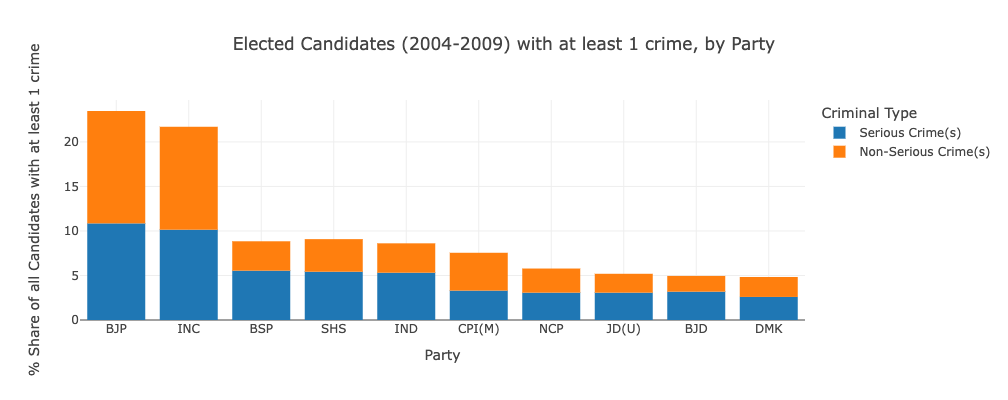

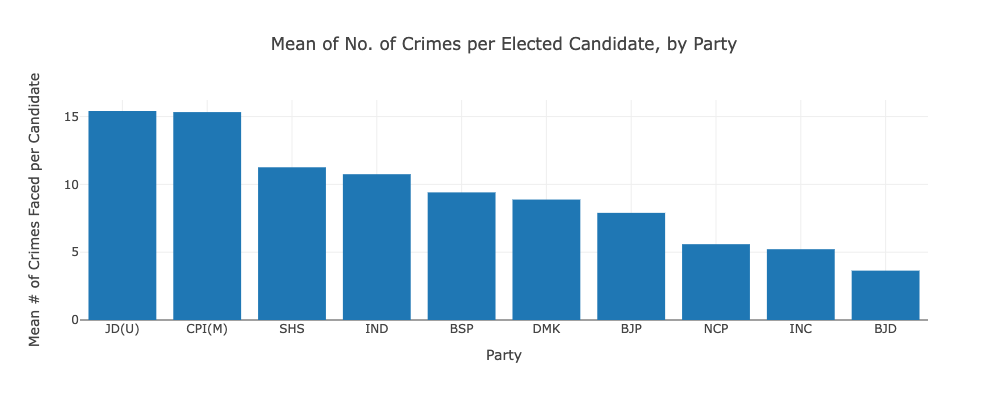

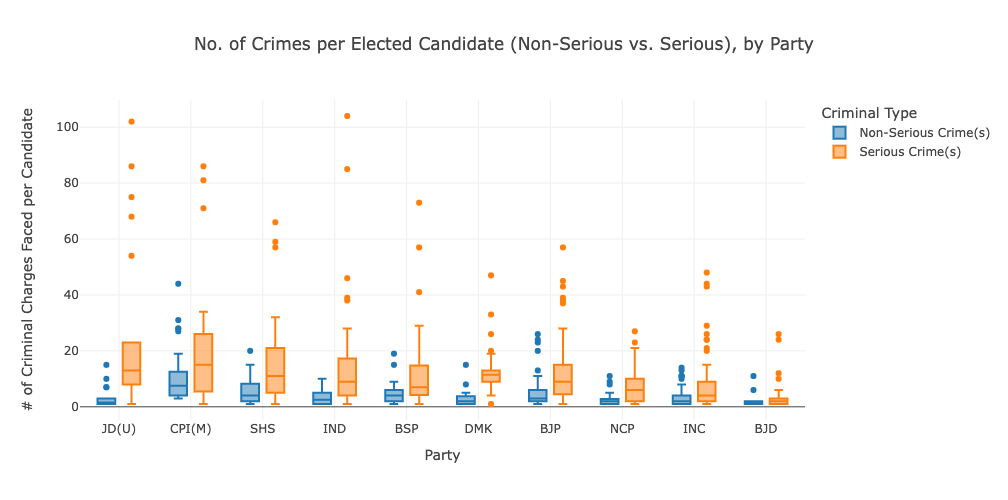

In [611]:

crim_elections['adr_major_crime'] = crim_elections['adr_major_crime'].fillna(0)
pd.options.mode.chained_assignment = None  # default='warn'

# elections_df may contain more than 1 rows for a single candidate (in case they won two or more times)
crim_elections = crim_elections.groupby(["winner_cand_id", "party"])[["num_crim",
                                                                      "adr_major_crime"]].max().reset_index()

#these are candidates that have changed parties from one election to other. I'll drop them 
def morethan1row(winner_id):
    nrows = crim_elections.loc[crim_elections["winner_cand_id"] == winner_id].shape[0]
    return (nrows > 1)
crim_elections = crim_elections.loc[~crim_elections["winner_cand_id"].apply(morethan1row)]

#We'll need this when wee plot the count of criminal candidates per party along with whether they're charged with serious crimes
crim_elections['crime_type'] = crim_elections["adr_major_crime"].apply(lambda x : 'Serious Crime(s)' if (x == 1.0) else 'Non-Serious Crime(s)')
data = (pd.DataFrame(crim_elections.groupby(['party', 'crime_type']).winner_cand_id.count()).reset_index())

#top 10 parties based on number of winning criminal candidates; The list was obtained as a result of an preliminary EDA.
top10parties = ['BJP', 'INC', 'BSP', 'SHS', 'IND', 'CPI(M)', 'NCP', 'JD(U)', 'BJD', 'DMK']
top10parties_names = ['Bhartiya Janta Party', 'Indian National Congress',
                      'Bahujan Samaj Party', 'SHS', 'Independent', 'CPI(M)', 'NCP', 
                      'Janta Dal United', 'BJD', 'DMK']

data = data.loc[data['party'].isin(top10parties)]
data = data.nlargest(20, 'winner_cand_id')
data['proportions'] = np.round(data.winner_cand_id.apply(lambda x : 100 * (x / data.winner_cand_id.sum())), 2)

#Finally,
bar = px.bar(data, x="party", y="proportions", color="crime_type", 
             labels={'proportions':'% Share of all Candidates with at least 1 crime',
                    'party':'Party', 'crime_type':'Criminal Type', 'winner_cand_id': 'No. of Elected Candidates with at least 1 crime'}, 
             height=400,
            title = 'Elected Candidates (2004-2009) with at least 1 crime, by Party',
            template = 'gridon',
            hover_name = 'party',
            hover_data = {'party': False, 'winner_cand_id': True},
            category_orders={"party": top10parties,
                              "crime_type": ["Serious Crime(s)", "Non-Serious Crime(s)"]})
bar.show()

#Next, I'll plot the mean number reported crimes per elected candidate for each party
ncands_by_party = pd.DataFrame(crim_elections.groupby('party')["winner_cand_id"].count())
ncands_by_party["num_crim_mean"] = np.round(crim_elections.groupby('party').num_crim.mean(), 2)
ncands_by_party["num_major_crim_cands"] = crim_elections.groupby('party').adr_major_crime.sum()
ncands_by_party['major_criminals_to_criminalwinners_ratio'] = np.round((ncands_by_party['num_major_crim_cands'] /  ncands_by_party['winner_cand_id'])*100, 2)
ncands_by_party = ncands_by_party.reset_index()
ncands_by_party = (ncands_by_party.loc[ncands_by_party['party'].isin(top10parties)].nlargest(10, 'num_crim_mean')).reset_index(drop = True)
ncands_by_party['winner_cand_id'] = ncands_by_party['winner_cand_id'].astype(float)
ncands_by_party['winner_to_otherparties_ratio'] =  np.round(ncands_by_party['winner_cand_id'].apply(lambda x:
                                                 100 * x / (ncands_by_party['winner_cand_id'].sum())), 2)  

bar2 = px.bar(ncands_by_party, x="party", y="num_crim_mean", 
             labels={'num_crim_mean': 'Mean # of Crimes Faced per Candidate',
                    'party':'Party',
                    'major_criminals_to_criminalwinners_ratio': '% of Elected Candidates within %{x} with Serious Crimes'}, 
             height=400,
            title = 'Mean of No. of Crimes per Elected Candidate, by Party',
            template = 'gridon',
            hover_name = 'party',
            hover_data = {'party': False,
                         'major_criminals_to_criminalwinners_ratio':True})
bar2.show()

df = crim_elections.loc[crim_elections.party.isin(top10parties)]
fig = px.box(df, x="party", y="num_crim", color="crime_type",
            height = 500, title = 'No. of Crimes per Elected Candidate (Non-Serious vs. Serious), by Party',
            labels = {'party':'Party', 'num_crim':'# of Criminal Charges Faced per Candidate', 'crime_type': 'Criminal Type'},
            template = 'gridon',
            category_orders = {'party': ['JD(U)', 'CPI(M)', 'SHS', 'IND', 'BSP', 'DMK', 'BJP', 'NCP', 'INC', 'BJD']})
fig.show()

Note: The top 10 parties are first chosen based on # of winning candidates with at least one crime charges against them during 2004-2009. The number of candidates with major criminal charges are then calculated for each of the top 10 parties and then plotted alongside the blue bars. 

As we can see in the top chart, BJP and INC, being the two largest parties in India, don't differ much in terms of their shares of winning candidates who had at least 1 crime and those who had at least 1 major crime. It seems that for both BJP and INC, the distribution of non-serious vs. serious criminal candidates are fairly balanced. 

As evident in the middle chart, Janta Dal United or JD(U) and Communist Party of India (Marxist) (CPI(M)) are both fairly levels in terms of average no. of criminal charges per candidate within their respective parties. However, as presented by the hover tooltip, JD(U) has a higher proportion of within-party criminal candidates who are charged with serious crimes (59.05%) as compared to CPI(M) which had 43.75% of its criminal candidates charged with serious crimes. An interesting thing to note here would be that both JD(U) and CPI(M) are dominant in Indian states Bihar and West Bengal, both of which are considered one of India's poorest states (but also in terms of health, education and public amenities)**.

**Cite: https://www.livemint.com/Politics/2mYGqXDSb37bediFJmGUvL/Indias-BIMARU-states-developing-but-not-catching-up.html (Fig: MPI of Indian states)

As stated previously in this writeup, the num_crim variable has a significant amount of outliers. But it's interesting to note here, as shown by the orange boxplots in bottom-most figure, the most of the outliers for num_crim variable are among the group of candidates who are charged with serious crimes (ie. the yellow boxplots). This somewhat explains why JD(U) and CPI(M) are the top 2 parties in terms of average number of crimes per winning candidate: it's because they have outlier candidates with as high as >80 crimes! This poses the question:


### Are some outliers (based on num_crime) simply cases of bad data (eg. overcounting)?
- It seems plausible that for certain candidates, 'num_crim' vastly overestimates the number of crimes they are charged for. One example is the case of 'Chotubhai A Vasava" who is famously touted as a 'Kingmaker' but is only charged with 24 criminal cases (as per this news report (cite)). We can see that our dataset overestimates Vasava's criminal history. 

#### Arguments in favour of including these outliers for my analyses
- Most of these candidates, for whom num_crim has been overestimated, have committed at least one major crime (ie. murder, attempt to murder, robbery, financial fraud and etc.) Removing these observations from our consideration would imply loss of important data and insights: how does the election of serious criminals affect economic growth?
- **Since I'm using 'num_crim' as a variable to simply categorize observations into binary groups (criminal or non-criminal), and thus am not using 'num_crim' as a explanatory variable for any kind of regression, these outliers or  overestimated observations should not undermine the credibility of analyses in the forthcoming sections of this assignment.**


In [612]:
cands_20ormore = gen_elections.loc[gen_elections["num_crim"] >= 20]
ratio = round((cands_20ormore["adr_major_crime"].sum() / cands_20ormore.shape[0])*100, 2)
print(f"Proportion of Candidates with 20 or more charges who have committed at least one serious crime: {ratio}%")

Proportion of Candidates with 20 or more charges who have committed at least one serious crime: 89.74%


In [621]:
print(ncrim_by_cand["num_crim"].describe())
q75, q25 = np.percentile(ncrim_by_cand["num_crim"], [75 ,25])
iqr = q75 - q25
print(f"IQR is {iqr*3}")

count    3629.000000
mean        2.585836
std         7.492233
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       104.000000
Name: num_crim, dtype: float64
IQR is 3.0


### EDA: Criminality and Growth in Assets (from one election to next)
Political parties tend to believe candidates with dynastic or criminal pasts win elections, and that belief is easily expressed and is evident on the basis of some of the previous visualizations. 

It's interesting to ask: is the average politician in India is richer than the average person? Moreover, does getting in power (ie. winning an election) imply gain in wealth? Are elected criminals more likely to gain wealth over the their term of service?

In [622]:
#cannot group by sh_cand_id (not enough rows have the assigned id)
# adr_cand_id is unreliable as evidently different candidates can be found sharing the same adr_cand_id
df = affidavits_raw.groupby('adr_cand_name')[['ac_id', 'year', 'assets', 'liabilities', 'num_crim']].count()
df = df.loc[(df.ac_id >= 2) & (df.year >= 2) & (df.assets >= 2) & (df.liabilities >= 2) &
      (df.num_crim >= 2)]
print(df.shape[0])
df.head(10)

#wrap this into a function
def get_assets_growth(adr_cand_name):
    '''given a candidate name, function returns a dataframe where each row corresponds to an election
       in which the candidate participated and won; more importantly, 
       assets_growth variable tells the growth in assets which occured
       after the candidate won (ie. compared to assets declared in next election they participated in)'''
    result = affidavits_raw.loc[affidavits_raw.adr_cand_name == adr_cand_name]
    result = result.drop_duplicates(subset = ['year'])
    #STOP HERE IF RESULT.SHAPE[0] is < 2.
    if result.shape[0] >= 2:
        #in this case, we have 3 records
        #first sort by year
        result = result.sort_values('year') 
        result[['year', 'ac_id', 'adr_cand_name', 'winner', 'num_crim']]
     
        result['assets_growth'] = -(np.log(result['assets']) - np.log(result.shift(-1)['assets']))*100
        result['assets_growth_abs'] = -(result['assets'] - result.shift(-1)['assets'])
        
        result = result.loc[result['winner'] == 1]
        result = result.loc[~result['assets_growth'].isna()]
        result = result[['year', 'ac_id', 'adr_cand_name', 'sh_cand_id', 'party', 'winner', 'num_crim', 'assets_growth', 
                         'assets_growth_abs', 'adr_major_crime',
            'punishment', 'age', 'ed']]
        return result
       
#test
get_assets_growth('a elumalai')



10316


year        ac_id adr_cand_name   sh_cand_id party  winner  num_crim  \
10319  2006  2007-34-016    a elumalai  34-11-016-1   IND       1         0   

       assets_growth  assets_growth_abs  adr_major_crime  punishment   age  \
10319     304.775928         10188506.0              0.0         0.0  41.0   

        ed  
10319  8.0

'assets_growth' represents % growth in assets which occured AFTER the current election. Eg. The row implies that the candidate, after being elected in 2006, 
grew their wealth by 305% until the next (2016) elections.'''


In [623]:
col_names = ['year', 'ac_id', 'adr_cand_name', 'sh_cand_id', 'winner', 'num_crim', 'assets_growth', 'adr_major_crime',
            'punishment', 'age', 'ed']
assets_growth_by_election = pd.DataFrame(columns = col_names)

df = df.reset_index()

for cand_name in df['adr_cand_name'].unique():
    cand_assets_result = get_assets_growth(cand_name)
    assets_growth_by_election = assets_growth_by_election.append(cand_assets_result)

assets_growth_by_election = assets_growth_by_election.loc[~(assets_growth_by_election['num_crim'].isin([-np.inf, np.inf])) &
         ~(assets_growth_by_election['punishment'].isin([-np.inf, np.inf])) &
         ~(assets_growth_by_election['adr_major_crime'].isin([-np.inf, np.inf])) &
         ~(assets_growth_by_election['ed'].isin([-np.inf, np.inf])) &
         ~(assets_growth_by_election['assets_growth'].isin([-np.inf, np.inf]))]

top10_assets_growth_cands = assets_growth_by_election.nlargest(10, 'assets_growth')
top10_assets_growth_cands['adr_cand_name'] = top10_assets_growth_cands['adr_cand_name'].apply(str.title)

#top10_assets_growth_cands

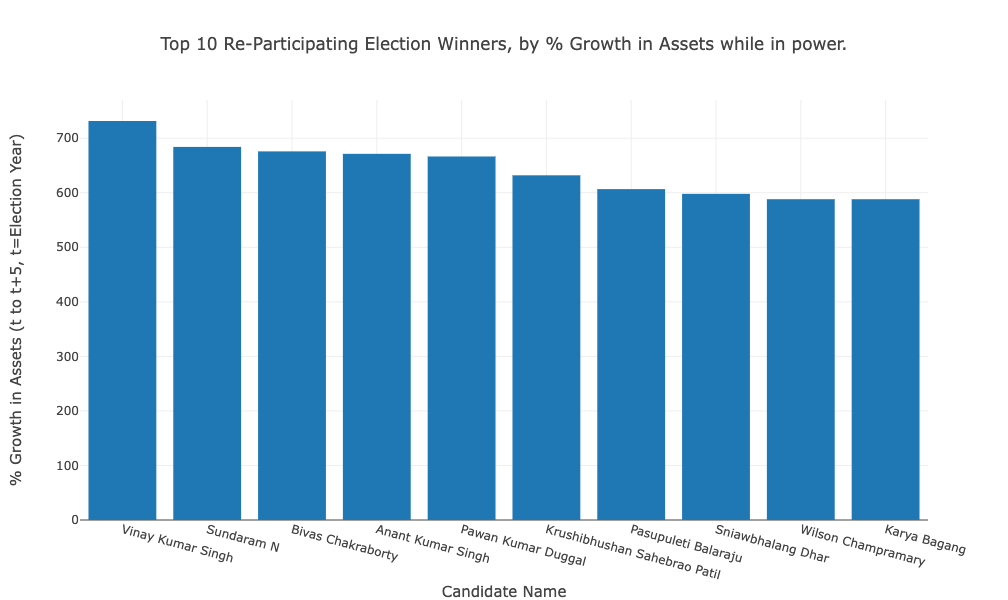

In [624]:
def to_inr(amount):
    return format_currency(amount, 'INR', locale='en_IN')

top10_assets_growth_cands['assets_growth_abs_curr'] = top10_assets_growth_cands['assets_growth_abs'].apply(to_inr)


top10cands = top10_assets_growth_cands['adr_cand_name']

fig = px.bar(top10_assets_growth_cands, x = 'adr_cand_name', y = 'assets_growth',
       orientation = 'v', 
      height = 600, template = 'gridon',
      hover_name = 'adr_cand_name',
      hover_data = {'party': True,
                    'year' : True,
                    'assets_growth_abs_curr': True,
                    'adr_cand_name': False,
                    'num_crim': True,
                    'adr_major_crime': True,
                    'assets_growth':True},
     labels = {'num_crim' : '# of Crimes Charged',
                    'assets_growth' : '% Growth in Assets (t to t+5, t=Election Year)',
                    'assets_growth_abs_curr': 'Abs. Growth in Assets',
                    'party' : 'Party',
                    'year' : 'Year of Election',
                    'committed_major_crime' : 'Charged with Serious Crime(s)?'},
    title = 'Top 10 Re-Participating Election Winners, by % Growth in Assets while in power.')
fig.update_xaxes(
        tickangle = 15,
        title_text = "Candidate Name",
        title_font = {"size": 15},
        title_standoff = 25)

fig.update_yaxes(
        title_text = "% Growth in Assets (t to t+5, t=Election Year)",
        title_standoff = 25,
        title_font = {"size": 15})

fig.show()

- Top 2 candidates were from BJP and INC respectively. Vinay Kumar Singh (BJP) won an election in 2010 and gained approximately 2 Cr. INR or about 341k CAD while staying in power for 5 years. Sundaram N (INC) gained 14 Cr. INR or 2.3 Million CAD while staying in power, but with a slower growth rate than that for Vinay Kumar Singh.
- Only 2 of the top 10 candidates here, namely Anant Kumar Singh and Pawan Kumar Duggal, are charged with at least 1 crime(s). 
- Pawan Kumar Duggal, ranking # 5 on this list, has 13 crimes against him (incl. serious crimes) and gained 40 Lac INR. Anant Kumar Singh, raking # 4 on this list, has 1 crime against him and gained 27 Cr INR or 4.6 Million CAD!


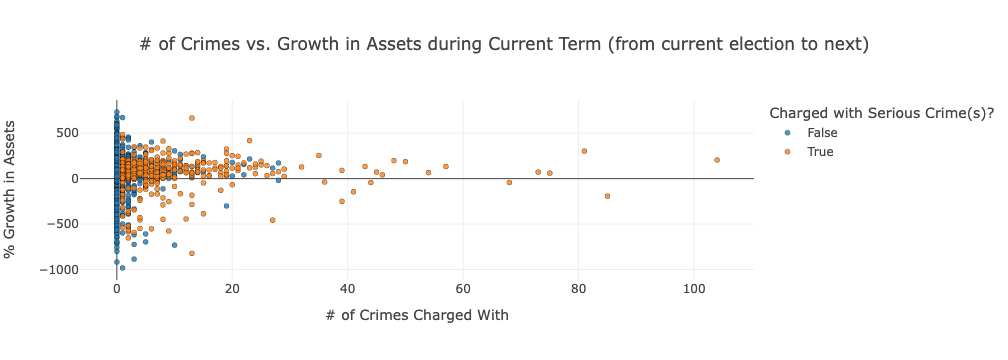

In [625]:
assets_growth_by_election['committed_major_crime?'] = assets_growth_by_election['adr_major_crime'].apply(lambda x: True
                                                                                                         if (x == 1.0) else False)
fig = px.scatter(assets_growth_by_election, x = 'num_crim', 
           y = 'assets_growth',
          color = 'committed_major_crime?',
          template = 'gridon',
           labels = {'num_crim' : '# of Crimes Charged With',
                    'assets_growth' : '% Growth in Assets',
                    'committed_major_crime?' : 'Charged with Serious Crime(s)?'},
            title = '# of Crimes vs. Growth in Assets during Current Term (from current election to next)')

fig.update_traces(opacity = 0.8, marker=dict(size=5,
                              line=dict(width=0.5,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

Observations: There's a lot of overlapping along with significant amount of noise. No clusters or trends are immediately visible. As a visual guess, we can say that there were more of the elections where the winning candidate suffered sub-zero asset growth rates post-election.

In [626]:
#prep data
assets_growth_by_election = assets_growth_by_election[['num_crim', 'adr_major_crime',
            'punishment', 'age', 'ed', 'assets_growth']]
assets_growth_by_election['num_crim'] = assets_growth_by_election['num_crim'].astype(int)
print(assets_growth_by_election.shape[0])
assets_growth_by_election = assets_growth_by_election.dropna()
print(assets_growth_by_election.shape[0])

import statsmodels.formula.api as smf
results_2 = smf.ols('assets_growth ~ num_crim + age + punishment + ed + C(adr_major_crime)', data=assets_growth_by_election).fit()
print(results_2.summary().tables[1])

2901
2719
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   170.1224     25.078      6.784      0.000     120.949     219.296
C(adr_major_crime)[T.1.0]    -1.1776     13.656     -0.086      0.931     -27.954      25.599
num_crim                      0.3854      0.633      0.609      0.543      -0.856       1.627
age                          -2.1084      0.333     -6.323      0.000      -2.762      -1.455
punishment                   -0.3748      0.413     -0.908      0.364      -1.184       0.435
ed                           -0.0610      1.518     -0.040      0.968      -3.038       2.916


Our main independent variable of concern, ie. num_crim, has a statistically insignificant and near zero coefficient. Punishment, being a proxy of num_crim, and education (ed) don't fare any better and have near zero but statistically insignificant coefficients. This suggests there's definitely a need for more data and exploration in any causal effects criminality of a candidate may have on their ability to gain assets while stauing in power. 

On another note, the results suggest that age had a negative effect on asset growth rates in our data. The statistically significant (alpha = 0.01) coefficient is -2.1084, or more each additional year of candidate age, the growth rate in assets was 2.11 percentage points lower. 


## Studying effect of electing criminal politicians on economic growth
As a baseline analysis, I am looking at all constituencies which elected a criminal candidate between 2004-2009 and then visualize the growth in mean night-light density across all electing constituencies over time (4 years after and 4 years before the election). This implies that I am not accounting for the crime-status of the runner-up candidate (explain the concept of closed-elections and Prakash et all.'s methods). Nor am I accounting for the crime-status of the previous winner in the constituency. 

For the baseline analysis, I consider a candidate criminal if they have more than 1 criminal charges against them while participating in a certain election. Additional subsets of the data based on different thresholds (eg. num_crim >= 3, num_crim >= 6, etc.) are also created. **Cite Prakash et all. and describe how they categorized the criminal candidates.**

In [21]:
#This is the baseline definition that I've been using so far:
gen_elections_noncrim = gen_elections.loc[gen_elections["num_crim"] == 0]
print(f"No. of elections where a candidate with 0 charges was elected = {gen_elections_noncrim.shape[0]}")
gen_elections_crim = gen_elections.loc[gen_elections["num_crim"] >= 1]

# To refine my definition of criminality, I'll consider a candidate as criminal if they have at least 2 crime on their record
gen_elections_crim_thresh1 = gen_elections.loc[gen_elections["num_crim"] >= 2]
print(f"No. of elections where a criminal with 2 or more was elected = {gen_elections_crim_thresh1.shape[0]}")
gen_elections_noncrim_thresh1 = gen_elections.loc[gen_elections["num_crim"] < 2]

# To further refine my definition of criminality, threshold is raised to 6 crimes or more. 
gen_elections_crim_thresh2 = gen_elections.loc[gen_elections["num_crim"] >= 6]
print(f"No. of elections where a criminal with 6 or more cases was elected = {gen_elections_crim_thresh2.shape[0]}")
gen_elections_noncrim_thresh2 = gen_elections.loc[gen_elections["num_crim"] < 6]

#Classifying criminal candidates (thresh1) based on whether they have committed at least one serious crime (murder, financial fraud, etc.)
gen_elections_majorcrim = gen_elections.loc[gen_elections["adr_major_crime"] == 1.0]
print(f"No. of elections where a major-criminal was elected = {gen_elections_majorcrim.shape[0]}")
gen_elections_nonmajorcrim = gen_elections.loc[(gen_elections["num_crim"] >= 2) & (gen_elections["adr_major_crime"] != 1.0)]



No. of elections where a candidate with 0 charges was elected = 2495
No. of elections where a criminal with 2 or more was elected = 891
No. of elections where a criminal with 6 or more cases was elected = 490
No. of elections where a major-criminal was elected = 600


In [22]:


np.seterr(divide = 'ignore') 


def strip_year(var):
        return var[11:]
    
def get_nl_by_ac2(ac_id, election_year):
    #if str(ac_id)[:4] == '2007': this doesn't work as expected, year of election should work hopefully.
    if election_year <= 2007:
        nlresult = nl_con_2007.loc[nl_con_2007["ac07_id"] == ac_id]
    elif election_year > 2007:
        nlresult = nl_con_2008.loc[nl_con_2008["ac08_id"] == ac_id]
    return nlresult

def get_year_cols2(election_year):
    '''Helper function which takes election year as input and outputs an array 
    of 8 appropriate columns names which can be used to retrieve nightlights data 
    for 8 years (4 years before and after the election" from nl_con dataframe'''
    
    #because now we are also working with 2007 delim constituencies, need to check for whether ac_id is of 2007 or 2008 format
    # if str(ac_id)[:4] == '2007':
    if election_year <= 2007:
        year_cols_names = ["ac07_id", "num_cells"]
    #elif str(ac_id)[:4] == '2008':
    elif election_year > 2007:
        year_cols_names = ["ac08_id", "num_cells"]
    
    for i in list(range(-4, 5)):
        col = election_year+i
        year_cols_names.append(f"total_light{col}")
    
    return year_cols_names

def get_growth_raw_nl_by_year(gen_elections_df):
    #create empty dataframe with colnames
    column_names = ["ac_id" ,"num_cells", "variable", "value", "year", "rel_index", "light_density"]
    df = pd.DataFrame(columns = column_names)

    for index, row in gen_elections_df.iterrows():

        year = row["year"]
        ac_id = row["ac_id"]
        
    
        result = get_nl_by_ac2(ac_id, year)[get_year_cols2(year)]
        result = result.melt(id_vars = (get_year_cols2(year)[:2]))

        years = []
        for index, row in result.iterrows():
            to_add = strip_year(row["variable"])
            years.append(to_add)


        result = result.assign(year_of_election=years)

        result["year_of_election"] = result["year_of_election"].astype(int)

        result["rel_index"] = result["year_of_election"] - year

        if year <= 2007:
            result = result.rename(columns = {"ac07_id": "ac_id"})
        elif year > 2007:
             result = result.rename(columns = {"ac08_id": "ac_id"})
        #result = result.set_index("ac_id")

        result["avg_light_density"] = result["value"] / result["num_cells"]

        result_shift = result.shift(1)

        result["growth_nl_t-1"] = (np.log(result["avg_light_density"]) - np.log(result_shift["avg_light_density"]))*100

        df = df.append(result)
    return df

In [23]:

growth_raw_nl = get_growth_raw_nl_by_year(gen_elections_crim_thresh1)
growth_raw_nl['subset_name'] = 'Criminal [num_crim >= 2]'
growth_raw_nl_noncrimthresh1 = get_growth_raw_nl_by_year(gen_elections_noncrim_thresh1)
growth_raw_nl_noncrimthresh1['subset_name'] = 'Non-Criminal [num_crim < 2]'
#sns.regplot(x = 'rel_index', y = 'growth_nl_t-1', data = df)

In [24]:
growth_raw_nl = growth_raw_nl.append(growth_raw_nl_noncrimthresh1)
#print(growth_raw_nl.shape[0])
#df1.head(5)
#df1.tail(5)
#df2.avg_light_density.isna().sum()
growth_raw_nl_noncrimthresh1.avg_light_density.isna().sum()

0

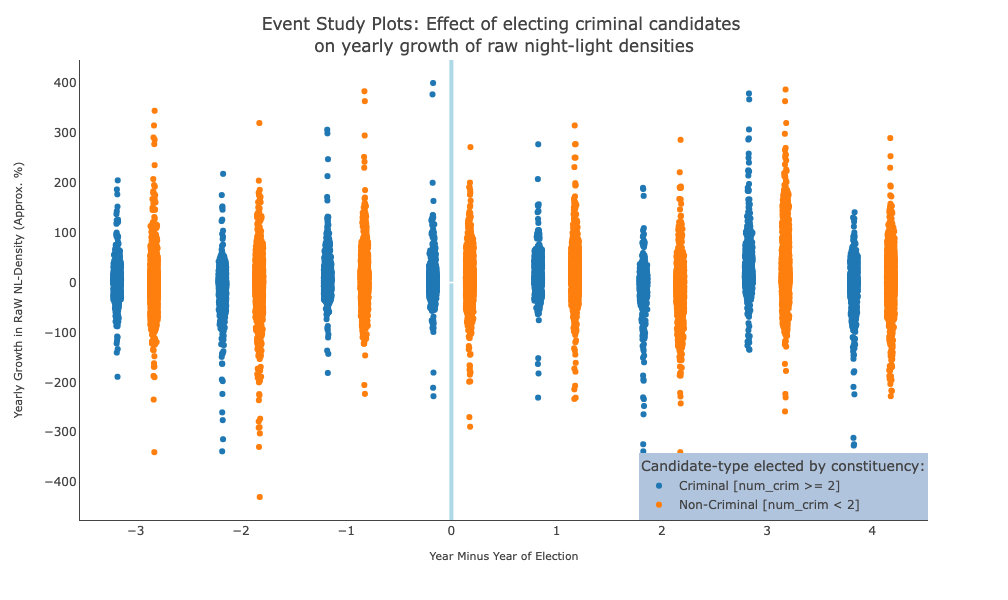

In [25]:
strip_plt = px.strip(growth_raw_nl, x = 'rel_index', y = 'growth_nl_t-1',
           color = 'subset_name', template = 'gridon')

strip_plt = strip_plt.update_layout(
            title_text='Event Study Plots: Effect of electing criminal candidates <br>on yearly growth of raw night-light densities',
            title_x=0.5,
            #plot_bgcolor= 'rgb(194, 208, 209)',
            height = 600,
            hoverlabel=dict(font_size=10, bgcolor='rgb(69, 95, 154)',
            bordercolor= 'whitesmoke'),
            legend=dict(title='Candidate-type elected by constituency:',
                        x=1,
                        y=0,
                        traceorder='normal',
                        bgcolor='LightSteelBlue',
                        xanchor = 'auto'),
           # updatemenus=updatemenus,
            yaxis = dict(
              showgrid = True,
              zeroline = True,
              showline = True,
              gridcolor = '#ffffff',
              gridwidth = 1.618,
              zerolinecolor = '#ffffff',
              zerolinewidth = 1.618,
              linewidth = 1,
              title = 'Yearly Growth in RaW NL-Density (Approx. %)',
              titlefont = dict(
                 size = 11,
                 color = '#444444'
              )),
              xaxis = dict(
              showgrid = False,
              zeroline = True,
              gridcolor = '#ffffff',
              gridwidth = 2,
              zerolinecolor = 'LIGHTBLUE',
              zerolinewidth = 4,
              linewidth = 1,
              title = 'Year Minus Year of Election',
              titlefont = dict(
                 size = 11,
                 color = '#444444'))
            )
strip_plt.show()

Each point in this strip plot represents yearly growth in raw nl-density (over t-1) in a given constituency in a given year relative to year of election. Because, we have at most one observation for each constituency in the gen_elections dataset, each constituency must have at most 4 points (1 for each year). The threshold for criminality is set as 2 (ie. if num_crim >= 2, then candidate is criminal and otherwise not). 

We find that the negative effects of electing a criminal candidate are not severe or immediately evident, especially if we use the current threshold for criminality. That is to say, we don't see dips in yearly nl-growth rate during years after the election of a criminal candidate as compared to growth-rates before observed before the election. However, if we had to compare the strip-plots for constituencies which elected a criminal vs. those that didn't, we find that the raw yearly growth rates were higher for a handful of constituencies that elected non-criminal candidates, especially during years -3, 2 and 4 (relative to year of election). 

**Another way to study the trends in nightlight-growth, and perhaps one which would save us computing time especially when considering the different thresholds we must consider, would be to set the y-variable as 'yearly growth in *mean* nl-density across all constituencies'.**

In [26]:
# Must alter the function a bit:
def get_growth_mean_nl_by_year(gen_elections_df):
    #create empty dataframe with colnames
    column_names = ["ac_id" ,"num_cells", "variable", "value", "year", "rel_index", "light_density"]
    df = pd.DataFrame(columns = column_names)

    for index, row in gen_elections_df.iterrows():

        year = row["year"]
        ac_id = row["ac_id"]
        
    
        result = get_nl_by_ac2(ac_id, year)[get_year_cols2(year)]
        result = result.melt(id_vars = (get_year_cols2(year)[:2]))

        years = []
        for index, row in result.iterrows():
            to_add = strip_year(row["variable"])
            years.append(to_add)


        result = result.assign(year_of_election=years)

        result["year_of_election"] = result["year_of_election"].astype(int)

        result["rel_index"] = result["year_of_election"] - year
        
        if year <= 2007:
            result = result.rename(columns = {"ac07_id": "ac_id"})
        elif year > 2007:
             result = result.rename(columns = {"ac08_id": "ac_id"})
        result = result.set_index("ac_id")

        result["light_density"] = result["value"] / result["num_cells"]

       # result_shift = result.shift(1)

       # result["growth_nl_t-1"] = (np.log(result["light_density"]) - np.log(result_shift["light_density"]))*100

        df = df.append(result)


    # group by rel_index, find mean light density and then shift(1) and find growth of mean light density 
    mean_nldensity_by_year = pd.DataFrame(df.groupby("rel_index").light_density.mean())

    mean_nldensity_by_year["growth_avg_nl_t-1"] = ((np.log(mean_nldensity_by_year["light_density"]) 
                                                    - np.log(mean_nldensity_by_year.shift(1)["light_density"]))*100) #uncomment for log
    mean_nldensity_by_year = mean_nldensity_by_year.reset_index()
    
    return mean_nldensity_by_year

In [27]:
#first thresh1
df1_1 = get_growth_mean_nl_by_year(gen_elections_crim_thresh1)
x1_1 = df1_1["rel_index"]
y1_1 = df1_1["growth_avg_nl_t-1"]
df1_2 = get_growth_mean_nl_by_year(gen_elections_noncrim_thresh1)
x1_2 = df1_2["rel_index"]
y1_2 = df1_2["growth_avg_nl_t-1"]
print("done")

done


In [28]:
#thresh2
df2_1 = get_growth_mean_nl_by_year(gen_elections_crim_thresh2)
x2_1 = df2_1["rel_index"]
y2_1 = df2_1["growth_avg_nl_t-1"]
df2_2 = get_growth_mean_nl_by_year(gen_elections_noncrim_thresh2)
x2_2 = df2_2["rel_index"]
y2_2 = df2_2["growth_avg_nl_t-1"]
print("done")

done


In [29]:
#thresh3 - major vs. non-major crim
df3_1 = get_growth_mean_nl_by_year(gen_elections_majorcrim)
x3_1 = df3_1["rel_index"]
y3_1 = df3_1["growth_avg_nl_t-1"]
df3_2 = get_growth_mean_nl_by_year(gen_elections_nonmajorcrim)
x3_2 = df3_2["rel_index"]
y3_2 = df3_2["growth_avg_nl_t-1"]
print("done")

done


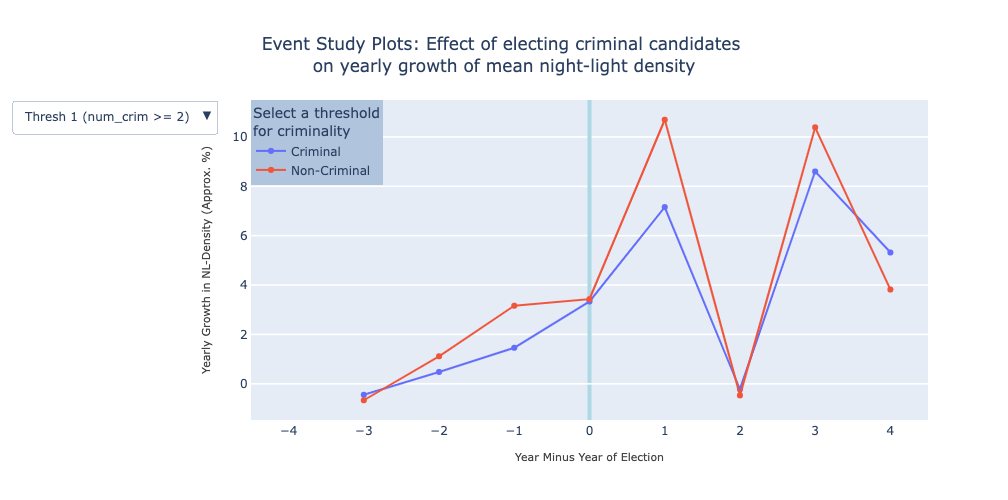

In [30]:
import plotly.graph_objects as go
# datagrab 1
lineplt_all = go.Figure()

lineplt_all.add_trace(go.Scatter(x=x1_1, y=y1_1,
                    mode='lines+markers',
                    name='Criminal'))
lineplt_all.add_trace(go.Scatter(x=x1_2, y=y1_2,
                   mode='lines+markers',
                    name='Non-Criminal'))


# datagrab 2
lineplt2 = go.Figure()

lineplt2.add_trace(go.Scatter(x=x2_1, y=y2_1,
                   mode='lines+markers',
                    name='Criminal (num_crim >= 6)'))
lineplt2.add_trace(go.Scatter(x=x2_2, y=y2_2,
                    mode='lines+markers',
                    name='Non-Criminal (num_crim < 6)'))

#default
# datagrab 1
lineplt = go.Figure()

lineplt.add_trace(go.Scatter(x=x1_1, y=y1_1,
                    mode='lines+markers',
                    name='Criminal'))
lineplt.add_trace(go.Scatter(x=x1_2, y=y1_2,
                    mode='lines+markers',
                    name='Non-Criminal'))




updatemenus = [
{'buttons': [
            {
            'method': 'update',
            'label': 'Thresh 1 (num_crim >= 2)',
            'args': [{'y': [dat.y for dat in lineplt_all.data]}]
            },
            {
            'method': 'update',
            'label': 'Thresh 2 (num_crim >= 6)',
            'args': [{'y': [dat.y for dat in lineplt2.data]}]
            }
            ],
'direction': 'down',
'showactive': True,
}
]

lineplt = lineplt.update_layout(
            title_text='Event Study Plots: Effect of electing criminal candidates <br>on yearly growth of mean night-light density',
            title_x=0.5,
            #plot_bgcolor= 'rgb(194, 208, 209)',
            height = 500,
            hoverlabel=dict(font_size=10, bgcolor='rgb(69, 95, 154)',
            bordercolor= 'whitesmoke'),
            legend=dict(title='Select a threshold<br>for criminality',
                        x=0,
                        y=1,
                        traceorder='normal',
                        bgcolor='LightSteelBlue',
                        xanchor = 'auto'),
            updatemenus=updatemenus,
            yaxis = dict(
              showgrid = True,
              zeroline = True,
              showline = True,
              gridcolor = '#ffffff',
              gridwidth = 1.618,
              zerolinecolor = '#ffffff',
              zerolinewidth = 1.618,
              linewidth = 1,
              title = 'Yearly Growth in NL-Density (Approx. %)',
              titlefont = dict(
                 size = 11,
                 color = '#444444'
              )),
              xaxis = dict(
              showgrid = False,
              zeroline = True,
              gridcolor = '#ffffff',
              gridwidth = 2,
              zerolinecolor = 'LIGHTBLUE',
              zerolinewidth = 4,
              linewidth = 1,
              title = 'Year Minus Year of Election',
              titlefont = dict(
                 size = 11,
                 color = '#444444'))
            )
lineplt = lineplt.update_traces(mode="lines+markers", hovertemplate= 'Growth in year %{x} relative to election: %{y:.2f}%')
lineplt.show()

We don't see an obvious negative effect in growth rates post the election of criminal candidates. It is evident that the annual growth rates in mean NL-density for the two group of constituencies (criminal-electing or otherwise) during years 1, 3, and 4 (ie. 3 of the 4 years after election) were higher than any of the growth rates recorded before the election. In other words, we cannot say that Night-Light density or hence economic growth decreseases or faces a negative effect post the election of criminal politicians. 

However, if we had to compare the two curves, we do learn more about how electing criminals might affect the constituencies on aggregate scale: 

When threshold is num_crim >= 2:
- The difference in yearly growth rates is stark especially for a lot of years in this plot: -1, 1 and 3. 
- the growth rate was never higher for criminal-electing constituencies during any of the years before or after the election.
- During 2nd year after election, the yearly growth rate (from year 1) dips below 0% for both criminal-electing and non-criminal-electing constituencies. 
- 1 year after the year of election, yearly growth rates reach respective peaks, 10.70% for non-criminal electing and 7.16% for criminal-electing constituencies. During this year, the difference in yearly growth rates for criminal-electing and non-criminal electing constituencies is the **starkest**, with criminal-electing constituencies recording a growth-rate which is a little more than 3% points lower than that for non-criminal-electing constituencies. 

When threshold is num_crim >= 6:
- During Years 2, 3, 4 after election, constituencies electing candidates with 6 or crimes (criminal according to threshold 2)perform marginally better than constituencies electing candidates with 2 or more crimes (criminal according to threshold 1). 
- During Year 2 after election, growth rates dipped for both criminal and non-criminal constituencies (similar to trend observed in the plot with threshold set as num_crim >= 2). However, when threshold is set to 6, we see that criminal electing constituencies performed better (0.33%) as compared to non-criminal electing constituences (num_crim < 6). 


Overall, we see that for the period after election, the annual growth rates in mean NL density for criminal-electing constituencies were lower than the annual growth rates for constituencies where non-criminals were elected. This overall trend is retained for 3 of the 4 years after election if we change the threshold for criminality to num_crim >= 6.

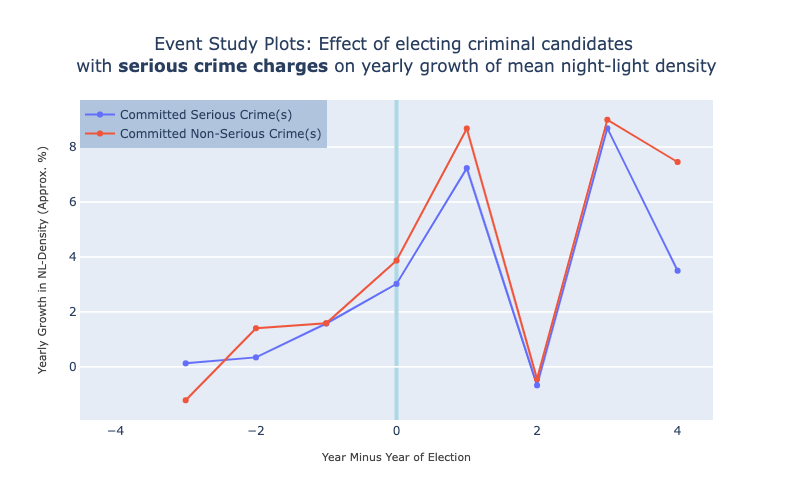

In [637]:
lineplt = go.Figure()

lineplt.add_trace(go.Scatter(x=x3_1, y=y3_1,
                    mode='lines+markers',
                    name='Committed Serious Crime(s)'))
lineplt.add_trace(go.Scatter(x=x3_2, y=y3_2,
                   mode='lines+markers',
                    name='Committed Non-Serious Crime(s)'))

lineplt = lineplt.update_layout(
            title_text='Event Study Plots: Effect of electing criminal candidates <br>with <b>serious crime charges</b> on yearly growth of mean night-light density',
            title_x=0.5,
            #plot_bgcolor= 'rgb(194, 208, 209)',
            height = 500,
            xaxis_showgrid=False,
            yaxis_showgrid=False,
            hoverlabel=dict(font_size=10, bgcolor='rgb(69, 95, 154)',
            bordercolor= 'whitesmoke'),
            legend=dict( x=0,
                        y=1,
                        traceorder='normal',
                        bgcolor='LightSteelBlue',
                        xanchor = 'auto'),
            yaxis = dict(
              showgrid = True,
              zeroline = True,
              showline = True,
              gridcolor = '#ffffff',
              gridwidth = 1.618,
              zerolinecolor = '#ffffff',
              zerolinewidth = 1.618,
              linewidth = 1,
              title = 'Yearly Growth in NL-Density (Approx. %)',
              titlefont = dict(
                 size = 11,
                 color = '#444444'
              )),
              xaxis = dict(
              #showgrid = True,
              zeroline = True,
              gridcolor = '#ffffff',
              gridwidth = 2,
              zerolinecolor = 'LIGHTBLUE',
              zerolinewidth = 4,
              linewidth = 1,
              title = 'Year Minus Year of Election',
              titlefont = dict(
                 size = 11,
                 color = '#444444'))
            )
lineplt = lineplt.update_traces(hovertemplate= 'Growth in year %{x} relative to election: %{y:.2f}%')
lineplt.show()

- The difference in yearly growth rates is stark especially for a lot of years in this plot: -2, 0, and 1. 
- the growth rate was higher for major-criminal-electing constituencies during year -3 relative to election year.
- During 2nd year after election, the yearly growth rate (from year 1) dips below 0% for both major-criminal-electing and non-major-criminal-electing constituencies. 
- During 3rd year after election, yearly growth revives and reaches a peak > 8% for both kinds of constituencies. 
- During 4th year after election, however, the difference in yearly growth rates for major-criminal-electing and non-major-criminal electing constituencies is the **starkest**, with major-criminal-electing constituencies recording a growth-rate which is approx. 4% points lower than that for non-criminal-electing constituencies. 

Overall, we see that for the period after election, the annual growth rates in mean NL density for major-criminal electing constituencies were lower than the annual growth rates for constituencies where non-major/non-serious criminals were elected.

### Next Steps: Towards RD Setup and Estimating Coefficients for understanding the effect of electing criminal politicians on economic growth

#### Creating Top-2 Elections Sample:
Based on Prakash et all's work, I am only looking at elections where only one of the top-2 candidates (in terms of vote-shares and hence position) is categorized as 'criminal' (based on a threshold of choice). The authors used the variable 'vote-margin' as the 'forcing variable', and I have done the same. Moreover, 'Vote-margin' is defined as the difference in vote-share (%) of the criminal candidate minues the vote-share (%) of the non-criminal candidate. Hence, setting the cutoff as vote-margin = 0 implies that all observations above the cutoff are for constituencies that elected a criminal candidate (ie. received the treatment) and all observations below the cutoff are constituencies that did not receive the treatment. 

In [31]:
def top2_cands_by_election():
    ''' Helper function generating the top 2 candidates (in terms of vote-shares)
    for any given election'''
    #empty dataframe to store the results
    column_names = ["ac_id", "year", "sh_cand_id", "cand_name", "position", "vote_share_percentage"]
    result_df = pd.DataFrame(columns = column_names)
    
    for index, row in gen_elections.iterrows(): #using gen_elections since it only contains one row per election (as compared to candidates df which has more than
        # 3+ rows for each election. This should save some computing time.
        year = row['year']
        ac_id = str(row['ac_id'])


        result = candidates.loc[(candidates['ac_id'] == ac_id) & (candidates['year'] == year)].nsmallest(2, 'position')[["ac_id",                                                                                                                "year", "sh_cand_id", 
                                                                                                                         "cand_name", "position", 
                                                                                                                         "vote_share_percentage"]]
        result_df = result_df.append(result)

    return result_df
#test
#top2_cands_by_election().head(5)

#### Compute vote-margins for each election
Vote-Margin is the forcing variable being used for this RD design. In our top-2 sample (ie. we only consider elections where only one of the top 2 candidates was a criminal), the vote-margin for any given election is defined as: vote-share (%) of the criminal candidate - vote-share (%) of the non-criminal candidate.


In [32]:
def get_vote_margin_by_election(crim_threshold):
    '''return a subset of elections where only one of the top two candidates are defined as criminal,
    based on the crim_threshold. The important column is 'vote_margin' which contains the difference in
    vote-share of criminal candidate and vote-share of non-criminal candidate for the given election.'''
    
    #first step: merge affidavits data with top 2 candidates data
    
    test = pd.merge(result_df, affidavits, on = ['ac_id', 'year', 'sh_cand_id'], how = 'inner')
    print(f"after initial merge with affidavits df: {test.shape[0]}")
   
    #a categorical variable to define criminality (using a threshold)
    test['is_criminal?'] = test['num_crim'].apply(lambda x: True if (x >= crim_threshold) else False)
    
    # Remove rows for elections where both candidates are either non-criminal or criminal
    # A quick solution is to check for duplicates; The is_criminal? values for any two rows corresponding to the same
    # election must ALWAYS be different. 
    test = test.drop_duplicates(subset = ['ac_id', 'year', 'is_criminal?'], keep = False)
    print(f'after dropping elections where both of top-2 candidates have same class of criminality: {test.shape[0]}')
    test.head(5)

    # to check if we have strictly 2 observations for each ac_id
    nrows_by_acid_dict = {'2007-02-001' : 2}

    for ac_id in test['ac_id'].unique():
        nrows = test.loc[test['ac_id'] == ac_id].shape[0]
        to_update = {ac_id : nrows}
        nrows_by_acid_dict.update(to_update)

    nrows_by_acid = pd.DataFrame.from_dict(data = {'ac_id' : nrows_by_acid_dict.keys(),
                                  'n_rows' : nrows_by_acid_dict.values()})

    acids_to_remove = nrows_by_acid.loc[nrows_by_acid['n_rows'] != 2]['ac_id']

    #Reduce scope ensure we have strictly 2 rows for each ac_id
    test = test.loc[~test['ac_id'].isin(acids_to_remove)]

    print(f'After ensuring 2 rows for each election: {test.shape[0]}')

    #Finally, we create a dataframe where each row corresponds to an unique election 
    # including a column called vote_margin where vote_margin is defined as: vote_share (criminal) - vote_share (non-criminal)
    test = test.reset_index().set_index(['ac_id', 'year'])

    ac_ids = []
    years = []
    vote_margins = []

    for index in test.index:
        ac_id, year = index
        if (ac_id in ac_ids) & (year in years):
            next
        else:
            subset = test.loc[ac_id, year].sort_values('is_criminal?', ascending = False)
            if subset.shape[0] == 2: #make sure two rows exists for each election
                vote_margin = (subset['vote_share_percentage'] - subset.shift(-1)['vote_share_percentage'])[0]
                ac_ids.append(ac_id)
                years.append(year)
                vote_margins.append(vote_margin)


    vote_margin_by_election = pd.DataFrame.from_dict(data = {'ac_id' : ac_ids,
                                  'year' : years,
                                  'vote_margin' : vote_margins})
    print(f'# rows in vote_margin_by_election (should be half of the previous step): {vote_margin_by_election.shape[0]}')
    return vote_margin_by_election


In [33]:
#Need to re-define the get_year_cols function as I only need nl-data for 4 years after the election
def get_year_cols3(election_year):
    '''Helper function which takes election year as input and outputs an array 
    of 4 appropriate columns names which can be used to retrieve nightlights data 
    for 4 years (4 years bafter the election" from nl_con dataframe'''

    #because now we are also working with 2007 delim constituencies, need to check for whether ac_id is of 2007 or 2008 format
    # if str(ac_id)[:4] == '2007':
    if election_year <= 2007:
        year_cols_names = ["ac07_id", "num_cells"]
    #elif str(ac_id)[:4] == '2008':
    elif election_year > 2007:
        year_cols_names = ["ac08_id", "num_cells"]
    
    for i in list(range(0, 5)):
        col = election_year+i
        year_cols_names.append(f"total_light{col}")

    return year_cols_names


#### Lowess Simulation Code 
Code Source: https://github.com/MikLang/Lowess_simulation/blob/master/Lowess_simulations.py

In [34]:
def loc_eval(x, b):
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)


def loess(xvals, yvals, data, alpha, poly_degree=1):
    all_data = sorted(zip(data[xvals].tolist(), data[yvals].tolist()), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)
    evalDF = pd.DataFrame(columns=['v','g'])
    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = min(xvals)-(.5*avg_interval)
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T
    for i in v:
        iterpos = i[0]
        iterval = i[1]
        iterdists = sorted([(j, np.abs(j-iterval)) for j in xvals], key=lambda x: x[1])
        _, raw_dists = zip(*iterdists)
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 if j[1]<=1 else 0)) for j in scaled_dists]
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))
        W         = np.diag(weights)
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ yvals)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })
        evalDF = pd.concat([evalDF, iterDF2])
    evalDF = evalDF[['v','g']]
    return(evalDF)


#### Choosing a set of definitions for the dependent variable
While it's clear that the dependent variable is 'growth in night-lights density', there are various definitions/ways to measure the dependent variable. If we think about definitions or proxies for development that suit best at constituency level of analysis, following options come to mind:
- Cumulative or Compound Average Annual Growth Rate (%) in NL-Density over 4 years after election for given constituency
- The Average Annual/Yearly Growth Rate (%) in Night-Light Density over 4 years after election for given constituency
- The Raw Annual/Yearly Growth Rate (%) in Night-Light Density for each of the 4 years after election for given constituency
- Roads Data -- NOT POSSIBLE AS COULDN'T FIND THE CONSTITUENCY-LEVEL ESTIMATES 


#### Dependent Variable Definition I: Cumulative or Compound Average Annual Growth Rate (%) in NL-Density over 4 years after election for given constituency (ie. from election year (t) to t+4)
Methodology: CAGRs are calculated for each election. Rows are binned together using a certain bin_width (eg. 0.15% increments in vote-margin), and averages of CAGRs within vote-margin bins are calculated and plotted on the scatterplot.

\begin{aligned}&CAGR= \left ( \frac{EV}{BV} \right ) ^{\frac{1}{n}}-1\times 100\\&\textbf{where:}\\&EV = \text{NL-Density in given constituency, in year 4 after election}\\&BV = \text{NL-Density in given constituency, in year of election}\\&n = \text{Number of years = 4}\end{aligned}

In [35]:
result_df = top2_cands_by_election()
vote_margin_by_election_CAGR = get_vote_margin_by_election(2)
vote_margin_by_election_CAGR.head(5)

after initial merge with affidavits df: 6024
after dropping elections where both of top-2 candidates have same class of criminality: 2434
After ensuring 2 rows for each election: 1850


/tmp/ipykernel_15165/2475510432.py:52: PerformanceWarning:

indexing past lexsort depth may impact performance.



# rows in vote_margin_by_election (should be half of the previous step): 925


ac_id  year  vote_margin
0  2007-02-002  2007       -13.63
1  2007-02-004  2007         6.26
2  2007-02-007  2007       -11.71
3  2007-02-009  2007       -13.75
4  2007-02-010  2007        14.43

In [36]:
#A new function to get nl-data based on our definition of dependent variable
def get_CAGR_nl(ac_id, year):   
    nl_result = get_nl_by_ac2(ac_id, year)[get_year_cols3(year)]
    nl_result = nl_result.melt(id_vars = (get_year_cols3(year)[:2]))
    nl_result['nl_density'] = nl_result['value'] / nl_result['num_cells']
    nl_result['year'] = nl_result['variable'].apply(strip_year)
    nl_result['rel_index'] = nl_result['year'].astype(int) - year
    
    #calculate CAGR
    #some checks:
    if nl_result.shape[0] >= 4:
        nl_y4 = nl_result.loc[nl_result['rel_index'] == 4]['nl_density'].values[0]
        nl_y0 = nl_result.loc[nl_result['rel_index'] == 0]['nl_density'].values[0]

        CAGR = ((nl_y4 / nl_y0)**(1/4)*100)

        return CAGR
    
vote_margin_by_election_CAGR['CAGR'] = vote_margin_by_election_CAGR.apply(lambda x: get_CAGR_nl(x.ac_id, x.year), axis=1)
#vote_margin_by_election[['ac_id', 'year']].apply(get_avg_yearly_growth_nl)
nrows_with_null = vote_margin_by_election_CAGR.CAGR.isna().sum()
print(f"we couldn't find CAGR for {nrows_with_null} elections out of {vote_margin_by_election_CAGR.shape[0]}")

/tmp/ipykernel_15165/4062704477.py:15: RuntimeWarning:

invalid value encountered in double_scalars



we couldn't find CAGR for 5 elections out of 925


In [37]:
print(vote_margin_by_election_CAGR.shape[0])
#drop na values (especially in 'growth_t-1')
vote_margin_by_election_CAGR = vote_margin_by_election_CAGR.dropna()
print(vote_margin_by_election_CAGR.shape[0])
#Also, remove rows where dependent variable is infinite
vote_margin_by_election_CAGR = vote_margin_by_election_CAGR.loc[~vote_margin_by_election_CAGR['CAGR'].isin([np.inf, -np.inf])]
vote_margin_by_election_CAGR.shape[0]

925
920


917

In [55]:
#wrap this in one function
def get_data_rdd(vote_margin_by_election_df, col_name): #eg. col_name is CAGR here
    rd_df = vote_margin_by_election_df[['vote_margin', col_name]]
    rd_df = rd_df.rename(columns = {'vote_margin' : 'x', col_name : 'Y'})

    threshold = 0 # for vote-margin

    #Finding optimal bandwidth
    bandwidth_opt = rdd.optimal_bandwidth(rd_df['Y'], rd_df['x'], cut=threshold)
    print("Optimal bandwidth:", bandwidth_opt)
    
    # restrict the dataset to be only observations within this bandwidth of the threshold.
    data_rdd = rdd.truncated_data(rd_df, 'x', bandwidth_opt, cut=threshold)
    
    return data_rdd


In [56]:
#wrap into a re-usable function
def get_binned_rd_df(data_rdd):
    # finding a suitable number for n_bins
    x_min = data_rdd['x'].min()
    x_max = data_rdd['x'].max()
    n_bins = (x_max - x_min) / (0.15) # so that each interval is an increment of 0.17%
    # The width of 0.17% was chosen after experimenting with different bin_widths and judging by 
    # the amount of noise vs. patterns visible
    n_bins

    data_binned = rdd.bin_data(data_rdd, 'Y', 'x', round(n_bins))
    data_binned = data_binned.loc[~data_binned['Y'].isin([-np.inf, np.inf])]
    data_binned = data_binned.loc[~data_binned['x'].isin([-np.inf, np.inf])]
    data_binned = data_binned.loc[~data_binned['Y'].isna()]

    #Want to fit two separate local regression lines

    data_binned = data_binned.assign(treatment=(data_binned["x"] > 0).astype(int))
    no_treatment = data_binned.loc[data_binned['treatment'] == 0]
    treatment = data_binned.loc[data_binned['treatment'] != 0]

    #loess function which is declared in the appendix of this notebook.
    #source: https://github.com/MikLang/Lowess_simulation/blob/master/Lowess_simulations.py
    evalDF_treatment = loess("x", "Y", data = treatment, 
                   alpha=0.7, poly_degree=2)
    evalDF_notreatment = loess("x", "Y", data = no_treatment, 
                   alpha=0.7, poly_degree=2)
    return (data_binned, evalDF_treatment, evalDF_notreatment)


In [58]:

data_rdd_CAGR = get_data_rdd(vote_margin_by_election_CAGR, 'CAGR')
model = rdd.rdd(data_rdd_CAGR, 'x', 'Y', cut=0, equation = 'Y ~ TREATED + x')
print(model.fit().summary().tables[1])


Optimal bandwidth: 6.86377606710423
Estimation Equation:	 Y ~ TREATED + x
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.0613      1.557     70.666      0.000     107.000     113.123
TREATED       -3.5431      2.837     -1.249      0.212      -9.121       2.034
x              0.4025      0.367      1.096      0.274      -0.319       1.124


#### Dependent Variable Definition II: Raw Annual Growth Rate in Mean Night-Light Density (from t-1 to t)
Methodology: Annual growth rates for each of 4 years after election are calculated for each constituency (using difference in natural logs of night-light densities between the current and previous periods). Instead of finding the average yearly growth rate for each constituency, I simply add the 4 different yearly growth rates to the dataset which is subsequently binned on the basis of vote-margin % (increments of 0.50%). 

In [59]:
#next, we do automate the procedure for all rows in the vote_margin_by_election_df
crim_thresh = 2
vote_margin_by_election = get_vote_margin_by_election(crim_thresh)
vote_margin_by_election = vote_margin_by_election.set_index(['ac_id', 'year'])

#empty dataframe to store results
col_names = ['ac_id', 'year', 'vote_margin', 'rel_index', 'growth_t-1']
master_results = pd.DataFrame(columns = col_names)


for ac_id, year in vote_margin_by_election.index:
    ac_id = str(ac_id)
    year = int(year)
    
    #Find nl data for given consituency (4 years after election year)
    nl_result = get_nl_by_ac2(ac_id, year)[get_year_cols3(year)]
    nl_result['year'] = year

    if year <= 2007:
        nl_result = nl_result.rename(columns = {'ac07_id' : 'ac_id'})
    if year > 2007:
        nl_result = nl_result.rename(columns = {'ac08_id' : 'ac_id'})
    
    #next merge nl_result with current row in vote_margin_by_election
    search = vote_margin_by_election.reset_index()
    to_match = search.loc[(search['ac_id'] == ac_id) & 
                                           (search['year'] == year)]
    result = pd.merge(to_match, nl_result, on = ['ac_id', 'year'])
    
    result_melt = result.melt(id_vars = ['ac_id', 'year', 'vote_margin', 'num_cells']) 
    result_melt['curr_year'] = (result_melt['variable'].apply(strip_year))
    result_melt['curr_year'] = result_melt['curr_year'].astype(int)
    result_melt['rel_index'] = result_melt['curr_year'].astype(int) - result_melt['year'].astype(int)
    result_melt['nl_density'] = result_melt['value'] / result_melt['num_cells']
    result_melt['growth_t-1'] = (np.log(result_melt['nl_density']) - np.log(result_melt.shift(1)['nl_density']))*100
    result_melt_final = result_melt[['ac_id', 'year', 'vote_margin', 'rel_index', 'growth_t-1']] #basically this is what we'll get for each row in the vote_margin_by_election df

    master_results = master_results.append(result_melt_final)
master_results.head(10)

after initial merge with affidavits df: 6024
after dropping elections where both of top-2 candidates have same class of criminality: 2434
After ensuring 2 rows for each election: 1850


/tmp/ipykernel_15165/2475510432.py:52: PerformanceWarning:

indexing past lexsort depth may impact performance.



# rows in vote_margin_by_election (should be half of the previous step): 925


ac_id  year  vote_margin rel_index  growth_t-1
0  2007-02-002  2007       -13.63         0         NaN
1  2007-02-002  2007       -13.63         1    6.750324
2  2007-02-002  2007       -13.63         2   -2.928797
3  2007-02-002  2007       -13.63         3   39.704691
4  2007-02-002  2007       -13.63         4  -24.113411
0  2007-02-004  2007         6.26         0         NaN
1  2007-02-004  2007         6.26         1   19.697383
2  2007-02-004  2007         6.26         2   -7.987437
3  2007-02-004  2007         6.26         3   10.579806
4  2007-02-004  2007         6.26         4   30.330739

In [60]:
print(master_results.shape[0]) #this should be approximately 5 times the previous step, but some merging may
#have failed (eg. nl data wasn't found for a row in vote_margin_by_election)

#drop na values (especially in 'growth_t-1')
master_results = master_results.dropna()
master_results.shape[0]

#Also, remove rows where dependent variable is infinite
master_results = master_results.loc[~master_results['growth_t-1'].isin([np.inf, -np.inf])]
master_results.shape[0]

4625


3664

In [61]:
rd_df_GR = master_results[['vote_margin', 'growth_t-1']]
rd_df_GR = rd_df_GR.rename(columns = {'vote_margin' : 'x', 'growth_t-1' : 'Y'})

threshold = 0 # for vote-margin

#bandwidth_opt was computed earlier
bandwidth_opt = 2.213980020915685
# restrict the dataset to be only observations within this bandwidth of the threshold.
data_rdd_GR = rdd.truncated_data(rd_df_GR, 'x', bandwidth_opt, cut=threshold)

In [63]:
model = rdd.rdd(data_rdd_GR, 'x', 'Y', cut=0, equation = 'Y ~ TREATED + x')
print(model.fit().summary().tables[1])

Estimation Equation:	 Y ~ TREATED + x
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6698      3.708      2.608      0.009       2.386      16.954
TREATED       -4.2949      6.704     -0.641      0.522     -17.464       8.874
x              1.3185      2.651      0.497      0.619      -3.890       6.527


#### Dependent Variable Definition III: Average Annual Growth Rate in Mean Night-Light Density
Methodology: Annual growth rates for each of 4 years after election are calculated for each constituency (using difference in natural logs of night-light densities). Then, for each constituency (or vote-margin %), the average annual growth rate is computed by taking the mean of the four yearly growth rates. 

In [64]:
result_df = top2_cands_by_election()
vote_margin_by_election_AAGR = get_vote_margin_by_election(2)

after initial merge with affidavits df: 6024
after dropping elections where both of top-2 candidates have same class of criminality: 2434
After ensuring 2 rows for each election: 1850


/tmp/ipykernel_15165/2475510432.py:52: PerformanceWarning:

indexing past lexsort depth may impact performance.



# rows in vote_margin_by_election (should be half of the previous step): 925


In [65]:
def get_avg_yearly_growth_nl(ac_id, year):   
    nl_result = get_nl_by_ac2(ac_id, year)[get_year_cols3(year)]
    nl_result = nl_result.melt(id_vars = (get_year_cols3(year)[:2]))
    nl_result['nl_density'] = nl_result['value'] / nl_result['num_cells']
    nl_result['year'] = nl_result['variable'].apply(strip_year)
    nl_result['rel_index'] = nl_result['year'].astype(int) - year
    
    #calculate average yearly growth in nl_density (t-1)
    nl_result['growthrate_nl_density_t-1'] = (np.log(nl_result['nl_density']) - np.log(nl_result.shift(1)['nl_density'])) #*100
    
    average_yearly_growth_nl_density = nl_result['growthrate_nl_density_t-1'].mean()
    
    return average_yearly_growth_nl_density
    
vote_margin_by_election_AAGR['average_yearly_growth_nl_density'] = vote_margin_by_election_AAGR.apply(lambda x: 
                                                                                            get_avg_yearly_growth_nl(x.ac_id, x.year), axis=1)
#vote_margin_by_election[['ac_id', 'year']].apply(get_avg_yearly_growth_nl)
nrows_with_null = vote_margin_by_election_AAGR.average_yearly_growth_nl_density.isna().sum()

print(f"we couldn't find night-lights data for {nrows_with_null} elections out of {vote_margin_by_election_AAGR.shape[0]}")

we couldn't find night-lights data for 10 elections out of 925


In [66]:
vote_margin_by_election_AAGR = vote_margin_by_election_AAGR.loc[~vote_margin_by_election_AAGR['average_yearly_growth_nl_density'].isin([np.inf, -np.inf])]
vote_margin_by_election_AAGR = vote_margin_by_election_AAGR.dropna()

In [67]:
data_rdd_AAGR = get_data_rdd(vote_margin_by_election_AAGR, 'average_yearly_growth_nl_density')
model = rdd.rdd(data_rdd_AAGR, 'x', 'Y', cut=0, equation = 'Y ~ TREATED + x')
print(model.fit().summary().tables[1])

Optimal bandwidth: 2.3197658692549026
Estimation Equation:	 Y ~ TREATED + x
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0926      0.020      4.540      0.000       0.052       0.133
TREATED       -0.0394      0.037     -1.063      0.290      -0.113       0.034
x              0.0134      0.014      0.971      0.333      -0.014       0.041


### Dependent Variable Definition =  CAGR but with Criminality-Threshold as num_crim >= 6.

IDEA: Increasing the threshold for criminality to num_crim >= 6 will increase the 'intensity' of the treatment. 


In [68]:
result_df = top2_cands_by_election()
vote_margin_by_election_thresh2 = get_vote_margin_by_election(6)

after initial merge with affidavits df: 6024
after dropping elections where both of top-2 candidates have same class of criminality: 1674
After ensuring 2 rows for each election: 1090


/tmp/ipykernel_15165/2475510432.py:52: PerformanceWarning:

indexing past lexsort depth may impact performance.



# rows in vote_margin_by_election (should be half of the previous step): 545


In [69]:
vote_margin_by_election_thresh2['CAGR'] = vote_margin_by_election_thresh2.apply(lambda x: get_CAGR_nl(x.ac_id, x.year), axis=1)
#vote_margin_by_election[['ac_id', 'year']].apply(get_avg_yearly_growth_nl)
nrows_with_null = vote_margin_by_election_CAGR.CAGR.isna().sum()
print(f"we couldn't find CAGR for {nrows_with_null} elections out of {vote_margin_by_election_CAGR.shape[0]}")

#drop na values (especially in 'growth_t-1')
vote_margin_by_election_thresh2 = vote_margin_by_election_thresh2.dropna()

#Also, remove rows where dependent variable is infinite
vote_margin_by_election_thresh2 = vote_margin_by_election_thresh2.loc[~vote_margin_by_election_thresh2['CAGR'].isin([np.inf, -np.inf])]
vote_margin_by_election_thresh2.shape[0]


data_rdd_thresh2 = get_data_rdd(vote_margin_by_election_thresh2, 'CAGR')

model = rdd.rdd(data_rdd_thresh2, 'x', 'Y', cut=threshold, equation = 'Y ~ TREATED + x')
print(model.fit().summary().tables[1])


/tmp/ipykernel_15165/4062704477.py:15: RuntimeWarning:

invalid value encountered in double_scalars



we couldn't find CAGR for 0 elections out of 917
Optimal bandwidth: 8.121409514202085
Estimation Equation:	 Y ~ TREATED + x
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    111.0619      1.969     56.393      0.000     107.185     114.939
TREATED       -4.7504      3.599     -1.320      0.188     -11.836       2.335
x              0.3778      0.407      0.929      0.354      -0.423       1.178


### Regression Discontinuity Plots

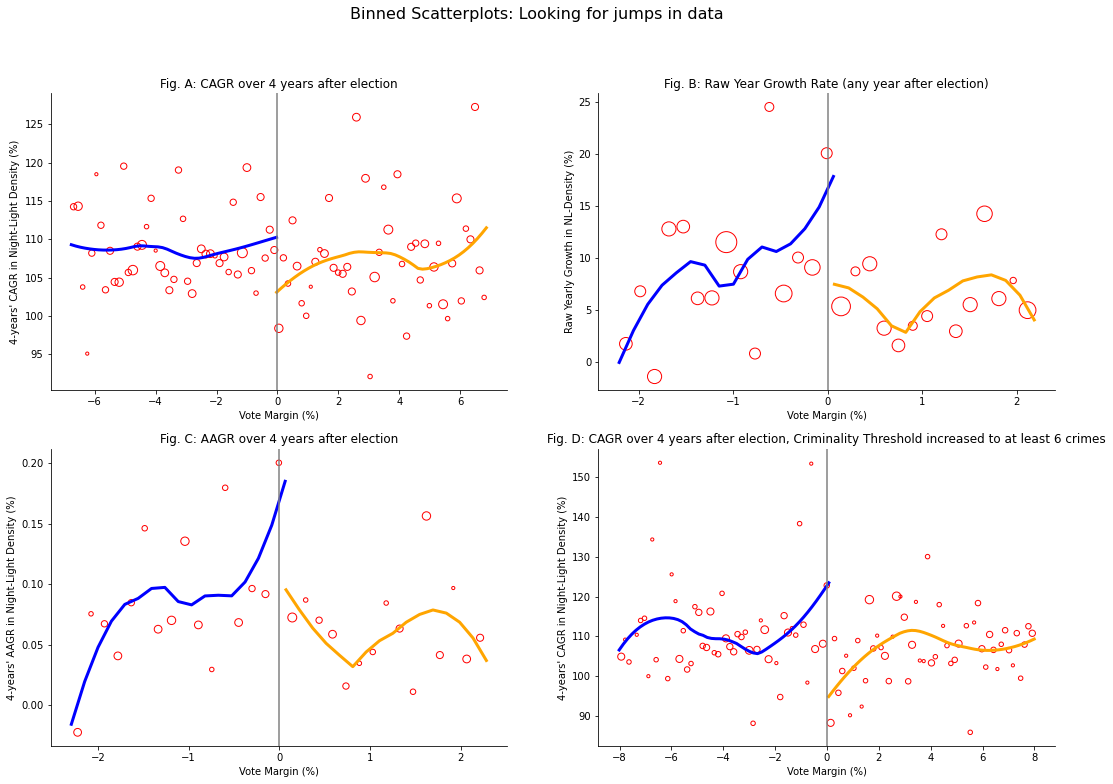

In [70]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(18, 12))


data_binned_CAGR, evalDF_treatment, evalDF_notreatment = get_binned_rd_df(data_rdd_CAGR)

ax1.scatter(data_binned_CAGR['x'], data_binned_CAGR['Y'],
    s = (10*data_binned_CAGR['n_obs']), facecolors='none', edgecolors='r')
    #SCATTER POINT SIZE IS WEIGHTED ACCORDING NUMBER OF OBSERVATIONS IN EACH BIN, BUT I CHOSE TO 
    # SCALE SIZE BY  FOR A BETTER INTERPRETATION.
ax1.plot(evalDF_treatment['v'], evalDF_treatment['g'], color='orange', linewidth= 3, label="Treatment")
ax1.plot(evalDF_notreatment['v'], evalDF_notreatment['g'], color='blue', linewidth= 3, label="No Treatment")
ax1.axvline(x=threshold, color='grey')
ax1.set_xlabel('Vote Margin (%)')
ax1.set_ylabel("4-years' CAGR in Night-Light Density (%)")

data_binned_GR, evalDF_treatment, evalDF_notreatment = get_binned_rd_df(data_rdd_GR)

ax2.scatter(data_binned_GR['x'], data_binned_GR['Y'],
    s = (10*data_binned_GR['n_obs']), facecolors='none', edgecolors='r')
    #SCATTER POINT SIZE IS WEIGHTED ACCORDING NUMBER OF OBSERVATIONS IN EACH BIN, BUT I CHOSE TO 
    # SCALE SIZE BY  FOR A BETTER INTERPRETATION.
ax2.plot(evalDF_treatment['v'], evalDF_treatment['g'], color='orange', linewidth= 3, label="Treatment")
ax2.plot(evalDF_notreatment['v'], evalDF_notreatment['g'], color='blue', linewidth= 3, label="No Treatment")
ax2.axvline(x=threshold, color='grey')
ax2.set_xlabel('Vote Margin (%)')
ax2.set_ylabel('Raw Yearly Growth in NL-Density (%)')


data_binned_AAGR, evalDF_treatment, evalDF_notreatment = get_binned_rd_df(data_rdd_AAGR)

ax3.scatter(data_binned_AAGR['x'], data_binned_AAGR['Y'],
    s = (10*data_binned_AAGR['n_obs']), facecolors='none', edgecolors='r')
    #SCATTER POINT SIZE IS WEIGHTED ACCORDING NUMBER OF OBSERVATIONS IN EACH BIN, BUT I CHOSE TO 
    # SCALE SIZE BY  FOR A BETTER INTERPRETATION.
ax3.plot(evalDF_treatment['v'], evalDF_treatment['g'], color='orange', linewidth= 3, label="Treatment")
ax3.plot(evalDF_notreatment['v'], evalDF_notreatment['g'], color='blue', linewidth= 3, label="No Treatment")
ax3.axvline(x=threshold, color='grey')
ax3.set_xlabel('Vote Margin (%)')
ax3.set_ylabel("4-years' AAGR in Night-Light Density (%)")

data_binned_thresh2, evalDF_treatment, evalDF_notreatment = get_binned_rd_df(data_rdd_thresh2)

ax4.scatter(data_binned_thresh2['x'], data_binned_thresh2['Y'],
    s = (10*data_binned_thresh2['n_obs']), facecolors='none', edgecolors='r')
    #SCATTER POINT SIZE IS WEIGHTED ACCORDING NUMBER OF OBSERVATIONS IN EACH BIN, BUT I CHOSE TO 
    # SCALE SIZE BY  FOR A BETTER INTERPRETATION.
ax4.plot(evalDF_treatment['v'], evalDF_treatment['g'], color='orange', linewidth= 3, label="Treatment")
ax4.plot(evalDF_notreatment['v'], evalDF_notreatment['g'], color='blue', linewidth= 3, label="No Treatment")
ax4.axvline(x=threshold, color='grey')
ax4.set_xlabel('Vote Margin (%)')
ax4.set_ylabel("4-years' CAGR in Night-Light Density (%)")

for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.suptitle('Binned Scatterplots: Looking for jumps in data', fontsize = 16)
ax1.set_title('Fig. A: CAGR over 4 years after election')
ax2.set_title('Fig. B: Raw Year Growth Rate (any year after election)')
ax3.set_title('Fig. C: AAGR over 4 years after election')
ax4.set_title('Fig. D: CAGR over 4 years after election, Criminality Threshold increased to at least 6 crimes')

plt.show()


## A note on RDD Results

Regardless of the choice of definition for the dependent variable, the coefficient(s) for the TREATMENT are not statistically significant. For instance, my RD model for CAGR as dependent variable suggests that electing a criminal politician decreases CAGR in night-time light density by 3.4 percentage points; however, this coefficient is statistically insignificant at alpha = 0.5.

For each of the four discontinuity plots, lowess curves or local flexible regression lines were plotted separately for points on either side of the threshold. Optimal bandwidth for the RDD model was calculated for each of the four plots. Lastly, each point in each of the 4 plots represents averaged values for the particular vote-margin bin (where each bin width is set to increments of 0.15%). 

#### The dependent variable (ie. growth rates in NL_density) used for event-study plots, RDD models or for plotting the discontinuity plots **is NOT net of state or fixed year effects**. 

Further Questions and Possible Explorations:

- Because of limitations with availibility of data, I didn't have enough election-worth data to visualize the effect of electing criminal politicians especially in constituencies that DID NOT elect a criminal politician in the previous election (ie. incumbent candidate was non-criminal, but winning candidate was criminal). 
- How would the results of my RDD model change if I were to calculate the dependent variable after accounting for state and fixed year effects?


## Conclusion

Despite failing to find any significant causal effect of electing criminals on constituency-level economic growth, this project was an exciting experience where I exposed myself to an exciting paper by Prakash et al., got to play with SHRUG database, and attempt an implementation of RDD design, all while learning Python! 

This project has instilled within me an affinity for applied work within Economics, especially within the sphere of Causal Inference. I'm excited to take forward the learnings to ECON 326 (which I'd be taking next semester) and hopefully, I'll revisit this project in future (and fill out some of the missing pieces of my puzzle). 